# Reddit Marketing Pipeline - Netflix vs Prime

In [ ]:
# Scrape r/netflix, r/primevideo (+ r/cordcutters), filter marketing talk, label themes,
# run sentiment (VADER), and produce comparison visuals (counts, heatmaps, trends, sentiment).

!pip install praw pandas numpy nltk scikit-learn matplotlib seaborn wordcloud

import os, time, re, json, urllib.request, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

#word cloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_OK = True
except Exception:
    WORDCLOUD_OK = False

# Reddit API
try:
    import praw
    PRAW_OK = True
except Exception:
    PRAW_OK = False

# ---------------- CONFIG ----------------
BASE = "/Users/saurabkohad/Downloads"   
OUT_DIR = os.path.join(BASE, "reddit_marketing_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

SUBREDDITS = ["netflix", "primevideo", "cordcutters"]  # add/remove as you like
DAYS_BACK = 365                                        # time window
LIMIT_PER_SUB = 1500                                   # submissions cap per subreddit

CONFIG = {
    "client_id":     "BCFtB9xGgaDp3yv2go8PDA",
    "client_secret": "TgQc2d2yHh6M82ruhJFoGAYs3SuDcQ",
    "user_agent":    "Dissertation Business Analytics by u/saurabkohad"
}

# Theme detection = multi-label classification via keyword matching
THEME_LEXICON = {
    "pricing":        r"(price|pricing|hike|increase|cost|expensive|cheap|discount|student|trial|free trial|annual|monthly|bundle price)",
    "offers":         r"(offer|promo|promotion|deal|coupon|voucher|cashback|sale)",
    "notifications":  r"(notification|push|email|reminder|nudge|alert|pop[- ]?up)",
    "recommendations":r"(recommend|recommended|algorithm|algo|personaliz|suggestion|because you watched|autoplay|continue watching)",
    "content":        r"(originals?|exclusive|catalogue|catalog|library|new release|show|movie|series|season|sports)",
    "bundle":         r"(bundle|prime (benefits|shipping)|amazon|music|twitch|one[- ]?day|delivery|kindle)",
    "service_quality":r"(ui|ux|interface|app|buffer|lag|4k|hdr|ads?|ad[- ]?supported|login|account|payment)",
    "churn_switch":   r"(cancel|churn|quit|left|unsubscribe|switch|switched|moved to|drop(ped)?)"
}
THEME_REGEX = {k: re.compile(v, re.IGNORECASE) for k, v in THEME_LEXICON.items()}

# Keyword filter = gate to mark posts/comments as “marketing-relevant”
FILTER_KEYWORDS = re.compile(
    r"(recommend|algorithm|notification|email|offer|discount|price|pricing|trial|free trial|bundle|"
    r"promotion|promo|cancel|churn|unsubscribe|switch|ui|ux|autoplay|continue watching|originals?|exclusive|ads?)",
    re.IGNORECASE
)

# utility functions
def clean_text(s):
    return re.sub(r"\s+", " ", str(s or "")).strip()

def detect_themes(text):
    if not text: 
        return ["other"]
    found = []
    for theme, rx in THEME_REGEX.items():
        if rx.search(text):
            found.append(theme)
    return found if found else ["other"]

def to_date(epoch):
    return dt.datetime.utcfromtimestamp(epoch).date()

def sentiment_scores(text, sia):
    if not text:
        return dict(neg=np.nan, neu=np.nan, pos=np.nan, compound=np.nan)
    return sia.polarity_scores(text)

# scraping functions
def praw_client(cfg):
    return praw.Reddit(client_id=cfg["client_id"],
                       client_secret=cfg["client_secret"],
                       user_agent=cfg["user_agent"])

def scrape_praw_subreddit(reddit, sub, since_utc, limit=1500):
    rows = []
    count = 0
    for submission in reddit.subreddit(sub).new(limit=None):
        if submission.created_utc < since_utc:
            break
        count += 1
        rows.append({
            "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
            "subreddit": sub,
            "type": "post",
            "id": submission.id,
            "created_utc": submission.created_utc,
            "created_date": to_date(submission.created_utc),
            "score": submission.score,
            "num_comments": submission.num_comments,
            "title": clean_text(getattr(submission, "title", "")),
            "body": clean_text(getattr(submission, "selftext", "")),
            "permalink": f"https://reddit.com{submission.permalink}"
        })
        # comments
        submission.comments.replace_more(limit=0)
        for c in submission.comments.list():
            rows.append({
                "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
                "subreddit": sub,
                "type": "comment",
                "id": f"{submission.id}_{getattr(c, 'id', 'na')}",
                "created_utc": getattr(c, "created_utc", submission.created_utc),
                "created_date": to_date(getattr(c, "created_utc", submission.created_utc)),
                "score": getattr(c, "score", np.nan),
                "num_comments": np.nan,
                "title": clean_text(getattr(submission, "title", "")),
                "body": clean_text(getattr(c, "body", "")),
                "permalink": f"https://reddit.com{submission.permalink}"
            })
        if count >= limit:
            break
    return pd.DataFrame(rows)

def pushshift_submissions(sub, since_utc, size=1000):
    url = (
        "https://api.pushshift.io/reddit/search/submission/"
        f"?subreddit={sub}&size={size}&sort=desc&sort_type=created_utc&after={int(since_utc)}"
    )
    with urllib.request.urlopen(url) as resp:
        data = json.loads(resp.read().decode("utf-8"))
    rows = []
    for d in data.get("data", []):
        rows.append({
            "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
            "subreddit": sub,
            "type": "post",
            "id": d.get("id"),
            "created_utc": d.get("created_utc"),
            "created_date": to_date(d.get("created_utc")),
            "score": d.get("score", np.nan),
            "num_comments": d.get("num_comments", np.nan),
            "title": clean_text(d.get("title")),
            "body": clean_text(d.get("selftext")),
            "permalink": d.get("permalink", "")
        })
    return pd.DataFrame(rows)

# scrape
since_date = dt.date.today() - dt.timedelta(days=DAYS_BACK)
since_utc = int(dt.datetime.combine(since_date, dt.time.min).timestamp())

dfs = []
if PRAW_OK and all(CONFIG.values()):
    reddit = praw_client(CONFIG)
    for sub in SUBREDDITS:
        print(f"Scraping r/{sub} via PRAW …")
        df_sub = scrape_praw_subreddit(reddit, sub, since_utc, limit=LIMIT_PER_SUB)
        dfs.append(df_sub)
        time.sleep(2)
else:
    print("PRAW not available or credentials missing; using Pushshift (posts only).")
    for sub in SUBREDDITS:
        print(f"Scraping r/{sub} via Pushshift …")
        df_sub = pushshift_submissions(sub, since_utc, size=LIMIT_PER_SUB)
        dfs.append(df_sub)
        time.sleep(1)

raw = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
raw = raw.dropna(subset=["title", "body"], how="all")
raw["text"] = (raw["title"].fillna("") + " " + raw["body"].fillna("")).str.strip()
raw["text_len"] = raw["text"].str.len()
raw = raw[raw["text_len"] > 0].copy()

raw_path = os.path.join(OUT_DIR, "reddit_raw.csv")
raw.to_csv(raw_path, index=False)
print(f"Saved raw scrape → {raw_path}   rows={len(raw)}")

# filter + clean
# Only marketing-relevant rows
mrk = raw[ raw["text"].str.contains(FILTER_KEYWORDS, na=False) ].copy()
print("Marketing‑relevant rows:", len(mrk))

# Theme detection (multi-label then explode)
mrk["themes"] = mrk["text"].apply(detect_themes)
mrk = mrk.explode("themes").rename(columns={"themes":"theme"})

# VADER
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()
sent = mrk["text"].apply(lambda t: sentiment_scores(t, sia)).apply(pd.Series)
mrk = pd.concat([mrk, sent], axis=1)

# Normalize platform if "Mixed" via keyword hits
def infer_platform(row):
    if row["platform"] in ["Netflix", "Prime"]:
        return row["platform"]
    t = str(row["text"]).lower()
    if "netflix" in t:
        return "Netflix"
    if "prime video" in t or "primevideo" in t or "on prime" in t or "amazon" in t:
        return "Prime"
    return "Mixed"

mrk["platform_norm"] = mrk.apply(infer_platform, axis=1)

clean_path = os.path.join(OUT_DIR, "reddit_marketing_clean.csv")
mrk.to_csv(clean_path, index=False)
print(f"Saved marketing‑clean → {clean_path}   rows={len(mrk)}")

# visualization utils
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 140

def savefig(name):
    plt.tight_layout()
    path = os.path.join(OUT_DIR, name)
    plt.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Scraping r/netflix via PRAW …
Scraping r/primevideo via PRAW …
Scraping r/cordcutters via PRAW …
Saved raw scrape → /Users/saurabkohad/Downloads/reddit_marketing_outputs/reddit_raw.csv   rows=51734


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/1986782343.py:190: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mrk = raw[ raw["text"].str.contains(FILTER_KEYWORDS, na=False) ].copy()


Marketing‑relevant rows: 28693
Saved marketing‑clean → /Users/saurabkohad/Downloads/reddit_marketing_outputs/reddit_marketing_clean.csv   rows=52913


In [33]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

cmp = mrk[mrk["platform_norm"].isin(["Netflix","Prime"])].copy()
ct = pd.crosstab(cmp["platform_norm"], cmp["theme"])
chi2, p, dof, exp = chi2_contingency(ct)
print(f"χ² test (theme mix): chi2={chi2:.2f}, dof={dof}, p={p:.6f}")


χ² test (theme mix): chi2=4028.91, dof=7, p=0.000000


In [ ]:
# effect size (Cramér's V) + adjusted residuals
import numpy as np, pandas as pd
from scipy.stats import chi2_contingency

# restrict to Netflix vs Prime only 
cmp = mrk[mrk["platform_norm"].isin(["Netflix","Prime"])].copy()

# contingency table (platform x theme)
ct = pd.crosstab(cmp["platform_norm"], cmp["theme"])
chi2, p, dof, exp = chi2_contingency(ct)

# cramér's V (effect size)
n = ct.values.sum()
phi2 = chi2 / n
r, k = ct.shape
cramers_v = np.sqrt(phi2 / min(k-1, r-1))
print(f"Chi-square={chi2:.2f}, dof={dof}, p={p:.6f}, N={n}")
print(f"Cramér's V={cramers_v:.3f}")

# adjusted residuals: which cells over/under-index?
# Adjusted residual formula: (O-E) / sqrt(E*(1-row_prop)*(1-col_prop))
O = ct.values.astype(float)
E = exp  # from chi2_contingency
row_prop = O.sum(axis=1, keepdims=True) / n
col_prop = O.sum(axis=0, keepdims=True) / n
adj_resid = (O - E) / np.sqrt(E * (1 - row_prop) * (1 - col_prop))

adj = pd.DataFrame(adj_resid, index=ct.index, columns=ct.columns)
adj_path = os.path.join(OUT_DIR, "stats_adjusted_residuals_theme_by_platform.csv")
adj.to_csv(adj_path)
print("Saved adjusted residuals →", adj_path)

# quick view of largest positive residuals
print("\nTop over-indexing cells (z >= 1.96):")
top_over = (adj.stack()
              .sort_values(ascending=False)
              .rename("z")
              .reset_index()
              .rename(columns={"level_0":"platform","level_1":"theme"}))
print(top_over[top_over["z"] >= 1.96].head(10))

# quick view of largest under-indexing cells (z <= -1.96)
print("\nTop under-indexing cells (z <= -1.96):")
top_under = (adj.stack()
               .sort_values(ascending=True)
               .rename("z")
               .reset_index()
               .rename(columns={"level_0":"platform","level_1":"theme"}))
print(top_under[top_under["z"] <= -1.96].head(10))


Chi-square=4028.91, dof=7, p=0.000000, N=14941
Cramér's V=0.519
Saved adjusted residuals → /Users/saurabkohad/Downloads/reddit_marketing_outputs/stats_adjusted_residuals_theme_by_platform.csv

Top over-indexing cells (z >= 1.96):
  platform_norm            theme          z
0         Prime           bundle  57.210092
1         Prime          pricing  21.429313
2       Netflix  service_quality  18.817315
3       Netflix          content  13.891223
4         Prime           offers   8.671478
5       Netflix     churn_switch   2.024955

Top under-indexing cells (z <= -1.96):
  platform_norm            theme          z
0       Netflix           bundle -57.210092
1       Netflix          pricing -21.429313
2         Prime  service_quality -18.817315
3         Prime          content -13.891223
4       Netflix           offers  -8.671478
5         Prime     churn_switch  -2.024955


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:44: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:45: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


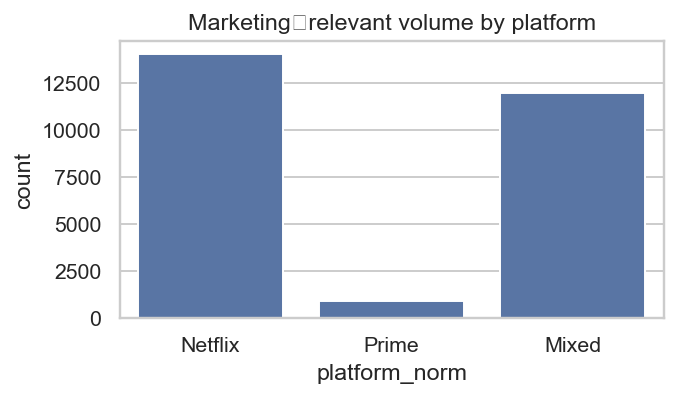

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/01_volume_by_platform.png


In [ ]:
# Volume by platform
plt.figure(figsize=(5,3))
sns.countplot(data=mrk, x="platform_norm", order=["Netflix","Prime","Mixed"])
plt.title("Marketing‑relevant volume by platform")
savefig("01_volume_by_platform.png")

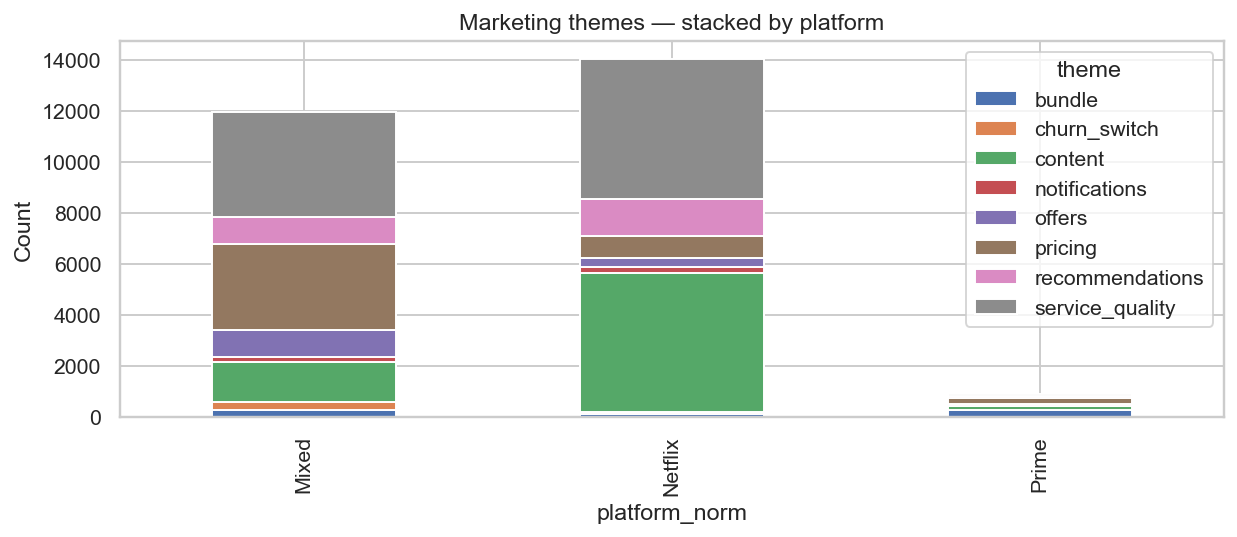

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/02_themes_stacked_by_platform.png


In [ ]:
# Theme distribution per platform (stacked)
theme_counts = (mrk.groupby(["platform_norm","theme"]).size()
                .reset_index(name="count"))
pivot_theme = theme_counts.pivot(index="platform_norm", columns="theme", values="count").fillna(0)
pivot_theme[sorted(pivot_theme.columns)] \
    .plot(kind="bar", stacked=True, figsize=(9,4))
plt.title("Marketing themes — stacked by platform")
plt.ylabel("Count")
savefig("02_themes_stacked_by_platform.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:44: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:45: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


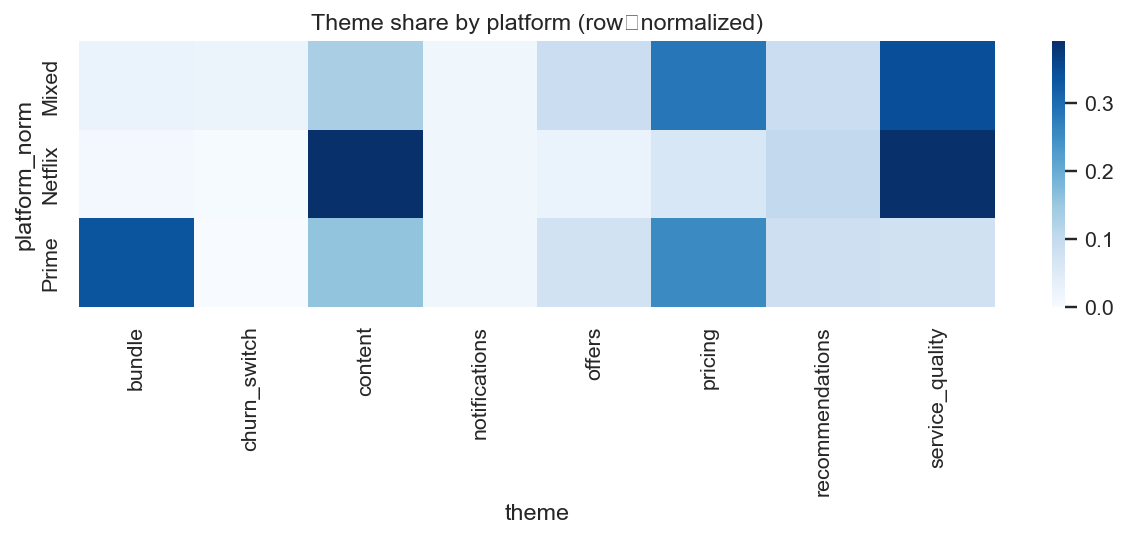

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/03_theme_heatmap_row_norm.png


In [ ]:
# Theme heatmap (normalized by row)
row_norm = pivot_theme.div(pivot_theme.sum(axis=1), axis=0)
plt.figure(figsize=(9,4))
sns.heatmap(row_norm[sorted(row_norm.columns)], cmap="Blues", vmin=0, vmax=row_norm.values.max())
plt.title("Theme share by platform (row‑normalized)")
savefig("03_theme_heatmap_row_norm.png")

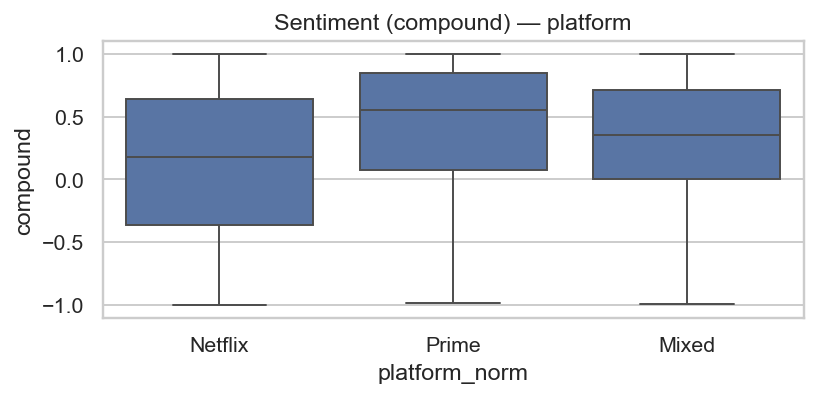

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/04_sentiment_platform_box.png


In [ ]:
# Sentiment by platform (box)
plt.figure(figsize=(6,3))
sns.boxplot(data=mrk, x="platform_norm", y="compound", order=["Netflix","Prime","Mixed"])
plt.title("Sentiment (compound) — platform")
savefig("04_sentiment_platform_box.png")

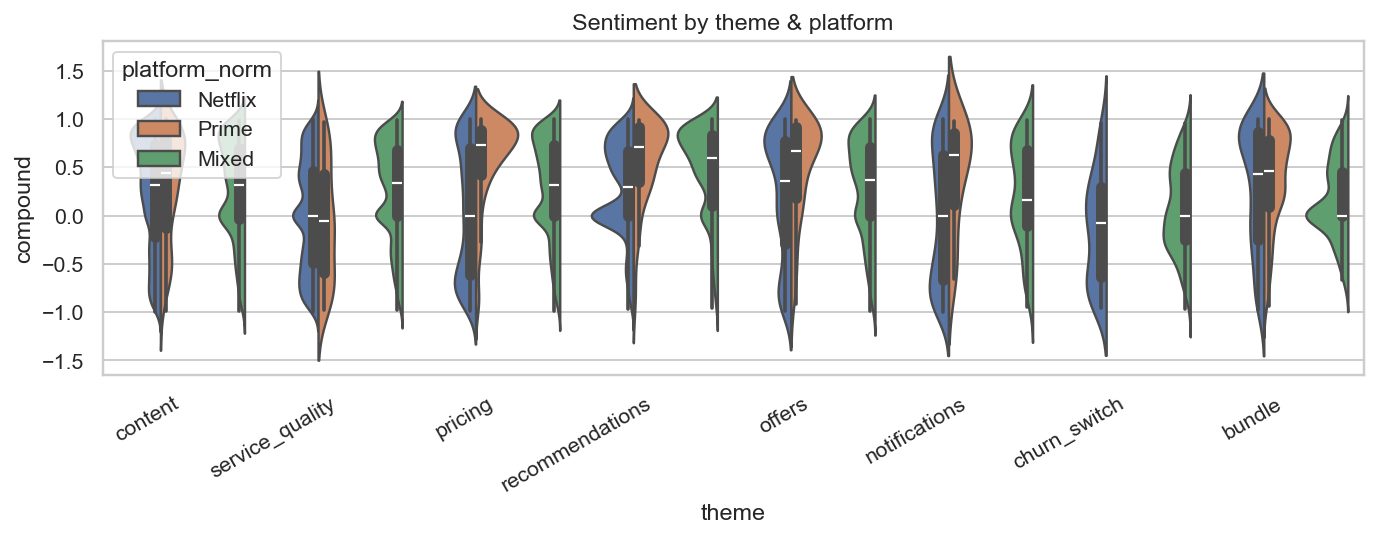

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/05_sentiment_theme_platform_violin.png


In [ ]:
# Sentiment by theme & platform (violin)
plt.figure(figsize=(10,4))
sns.violinplot(data=mrk, x="theme", y="compound", hue="platform_norm", split=True)
plt.xticks(rotation=30, ha="right")
plt.title("Sentiment by theme & platform")
savefig("05_sentiment_theme_platform_violin.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:44: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:45: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


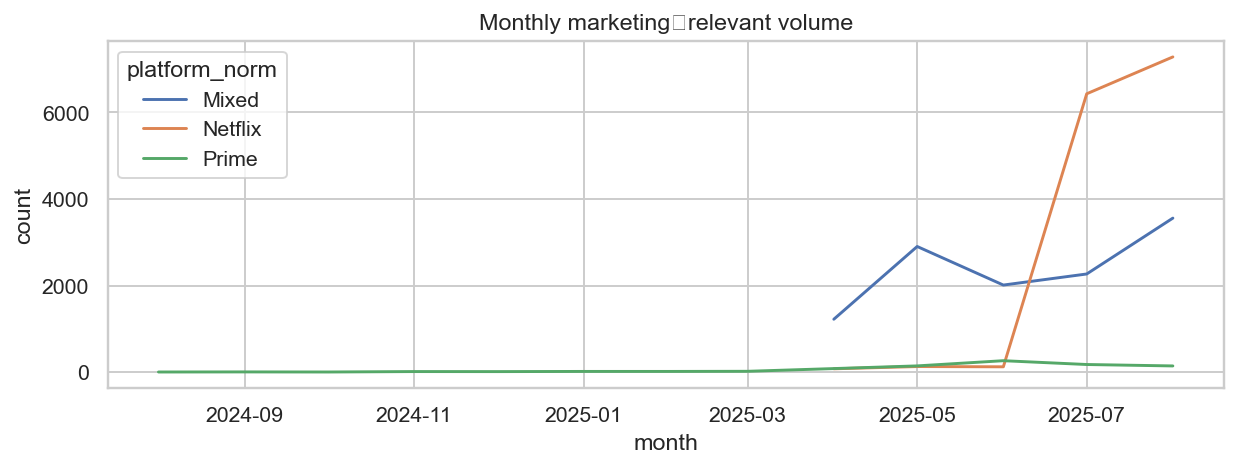

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/06_trend_monthly_volume.png


In [ ]:
# Monthly trends (volume)
mrk["month"] = pd.to_datetime(mrk["created_date"]).dt.to_period("M").dt.to_timestamp()
monthly = mrk.groupby(["platform_norm","month"]).size().reset_index(name="count")
plt.figure(figsize=(9,3.5))
sns.lineplot(data=monthly, x="month", y="count", hue="platform_norm")
plt.title("Monthly marketing‑relevant volume")
savefig("06_trend_monthly_volume.png")

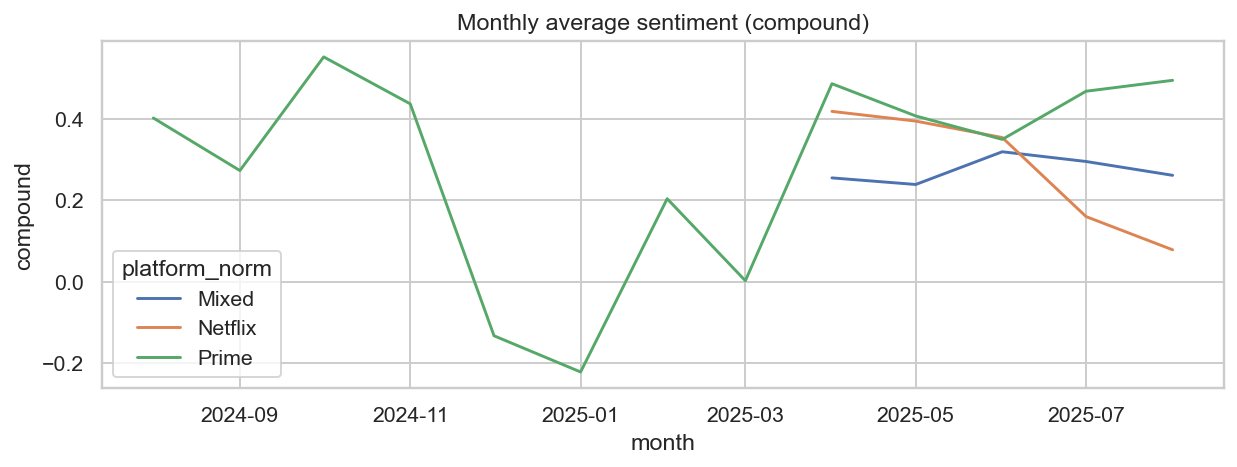

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/07_trend_monthly_sentiment.png


In [ ]:
#  Monthly average sentiment
monthly_sent = mrk.groupby(["platform_norm","month"])["compound"].mean().reset_index()
plt.figure(figsize=(9,3.5))
sns.lineplot(data=monthly_sent, x="month", y="compound", hue="platform_norm")
plt.title("Monthly average sentiment (compound)")
savefig("07_trend_monthly_sentiment.png")

Loaded /Users/saurabkohad/Downloads/ml-25m/ratings.csv (rows=25,000,095)


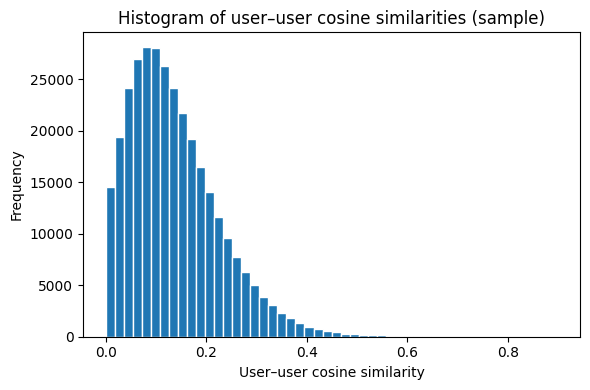

Saved: 08_user_user_cosine_hist.png  | pairs: 319600


In [ ]:
# User–user cosine similarity histogram 
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity

def load_ratings_df():
    # 1) Prefer a real in-memory DataFrame
    for name in ['ratings','ratings_df','ml_ratings','ratings_full','df_ratings','train_ratings']:
        obj = globals().get(name, None)
        if isinstance(obj, pd.DataFrame) and {'userId','movieId','rating'}.issubset(obj.columns):
            print(f"Using in-memory dataframe: {name} (rows={len(obj):,})")
            return obj[['userId','movieId','rating']].copy()

    # 2) Try common local paths
    CANDIDATE_PATHS = [
        "/Users/saurabkohad/Downloads/ml-latest/ratings.csv",
        "/Users/saurabkohad/Downloads/ml-latest-small/ratings.csv",
        "/Users/saurabkohad/Downloads/ml-25m/ratings.csv",
        "/Users/saurabkohad/Downloads/ml-20m/ratings.csv",
        "./ratings.csv"
    ]
    for p in CANDIDATE_PATHS:
        if os.path.exists(p):
            df = pd.read_csv(p, usecols=['userId','movieId','rating'])
            print(f"Loaded {p} (rows={len(df):,})")
            return df

    # 3) Globbing search (recursive) under Downloads
    root = "/Users/saurabkohad/Downloads"
    hits = glob.glob(os.path.join(root, "**/ratings*.csv"), recursive=True)
    if hits:
        df = pd.read_csv(hits[0], usecols=['userId','movieId','rating'])
        print(f"Loaded {hits[0]} (rows={len(df):,})")
        return df

    dats = glob.glob(os.path.join(root, "**/ratings.dat"), recursive=True)
    if dats:
        df = pd.read_csv(
            dats[0], sep="::", engine="python",
            names=["userId","movieId","rating","timestamp"],
            usecols=[0,1,2]
        )
        print(f"Loaded {dats[0]} (rows={len(df):,})")
        return df

    raise FileNotFoundError(
        "No ratings file found and no valid in-memory DataFrame. "
        "Edit CANDIDATE_PATHS to point at your MovieLens 'ratings.csv' "
        "(e.g., /Users/.../ml-25m/ratings.csv)."
    )

# Load ratings
ratings = load_ratings_df()

# Keep 'active' users (reduces noise & compute)
user_counts = ratings['userId'].value_counts()
active_users = user_counts[user_counts >= 50].index   # tweak threshold if needed
ratings = ratings[ratings['userId'].isin(active_users)]

# Build sparse user–item matrix
u = pd.Categorical(ratings['userId']).codes
i = pd.Categorical(ratings['movieId']).codes
v = ratings['rating'].astype(float).values
n_users, n_items = u.max()+1, i.max()+1
X = coo_matrix((v, (u, i)), shape=(n_users, n_items)).tocsr()

# Sample users and compute cosine similarities
rng = np.random.default_rng(42)
N_SAMPLE = min(800, X.shape[0])
idx = rng.choice(X.shape[0], size=N_SAMPLE, replace=False)
S = cosine_similarity(X[idx], X[idx])         # N x N
pairs = S[np.triu_indices_from(S, k=1)]       # off-diagonals

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(pairs, bins=50, edgecolor='white')
plt.xlabel('User–user cosine similarity')
plt.ylabel('Frequency')
plt.title('Histogram of user–user cosine similarities (sample)')
plt.tight_layout()
plt.savefig('08_user_user_cosine_hist.png', dpi=200)
plt.show()
print("Saved: 08_user_user_cosine_hist.png  | pairs:", pairs.size)


Baseline bias model RMSE = 0.8686 on 200,000 predictions


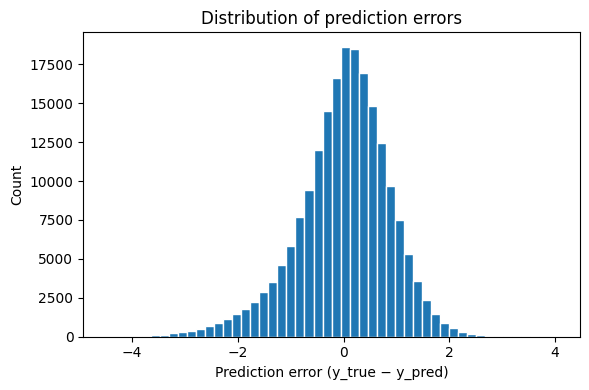

Saved: 09_error_distribution.png


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_28394/2623424311.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_user_rmse = preds_df.groupby('userId').apply(
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_28394/2623424311.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(per_user_rmse['rmse'], vert=True, labels=['per-user RMSE'])


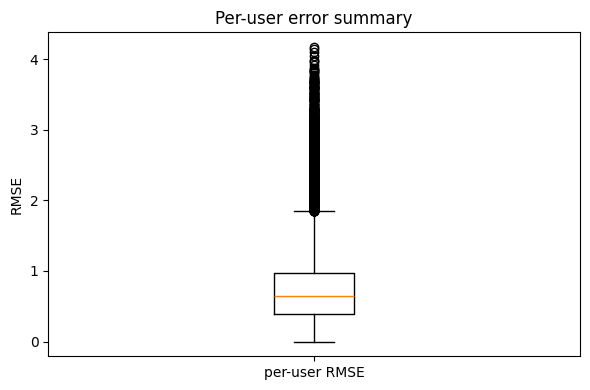

Saved: 09_rmse_per_user.png


In [ ]:
# baseline bias model + error analysis 
import numpy as np, pandas as pd, matplotlib.pyplot as plt

assert isinstance(ratings, pd.DataFrame) and \
       {'userId','movieId','rating'}.issubset(ratings.columns), \
       "ratings DataFrame with columns userId, movieId, rating is required."

# (A) Keep active users to avoid cold-start noise & speed up
min_rates = 20                      
active = ratings['userId'].value_counts()
ratings_f = ratings[ratings['userId'].isin(active[active >= min_rates].index)].copy()

# (B) Train/validation split 
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings_f, test_size=0.2, random_state=42)

# (C) Simple Baseline: global mean + regularised user & item biases
mu = train['rating'].mean()
lam_u, lam_i = 10.0, 25.0  # L2-like shrinkage

# user bias b_u = sum(r - mu)/(n + lam_u)
g_u = train.groupby('userId')['rating'].agg(['sum','count'])
b_u = (g_u['sum'] - g_u['count']*mu) / (g_u['count'] + lam_u)

# item bias b_i = sum(r - mu - b_u[u])/(n + lam_i)
tmp = train.join(b_u.rename('bu'), on='userId')
tmp['resid_u'] = tmp['rating'] - (mu + tmp['bu'])
g_i = tmp.groupby('movieId')['resid_u'].agg(['sum','count'])
b_i = g_i['sum'] / (g_i['count'] + lam_i)

def predict_row(u, i):
    return np.clip(mu + b_u.get(u, 0.0) + b_i.get(i, 0.0), 0.5, 5.0)

# (D) Build preds_df on a sample of test rows 
N_TEST = 200_000
test_s = test.sample(n=min(N_TEST, len(test)), random_state=42).copy()
test_s['y_pred'] = [predict_row(u, i) for u, i in zip(test_s['userId'].values, test_s['movieId'].values)]
preds_df = test_s.rename(columns={'rating':'y_true'})[['userId','movieId','y_true','y_pred']]

# Overall RMSE 
rmse = np.sqrt(((preds_df['y_true'] - preds_df['y_pred'])**2).mean())
print(f"Baseline bias model RMSE = {rmse:.4f} on {len(preds_df):,} predictions")

# error distribution & per-user RMSE plots
preds_df['residual'] = preds_df['y_true'] - preds_df['y_pred']
plt.figure(figsize=(6,4))
plt.hist(preds_df['residual'], bins=50, edgecolor='white')
plt.xlabel('Prediction error (y_true − y_pred)')
plt.ylabel('Count')
plt.title('Distribution of prediction errors')
plt.tight_layout()
plt.savefig('09_error_distribution.png', dpi=200)
plt.show()
print("Saved: 09_error_distribution.png")

# per-user RMSE
per_user_rmse = preds_df.groupby('userId').apply(
    lambda g: np.sqrt(((g['y_true'] - g['y_pred'])**2).mean())
).rename('rmse').reset_index()

plt.figure(figsize=(6,4))
plt.boxplot(per_user_rmse['rmse'], vert=True, labels=['per-user RMSE'])
plt.ylabel('RMSE')
plt.title('Per-user error summary')
plt.tight_layout()
plt.savefig('09_rmse_per_user.png', dpi=200)
plt.show()
print("Saved: 09_rmse_per_user.png")


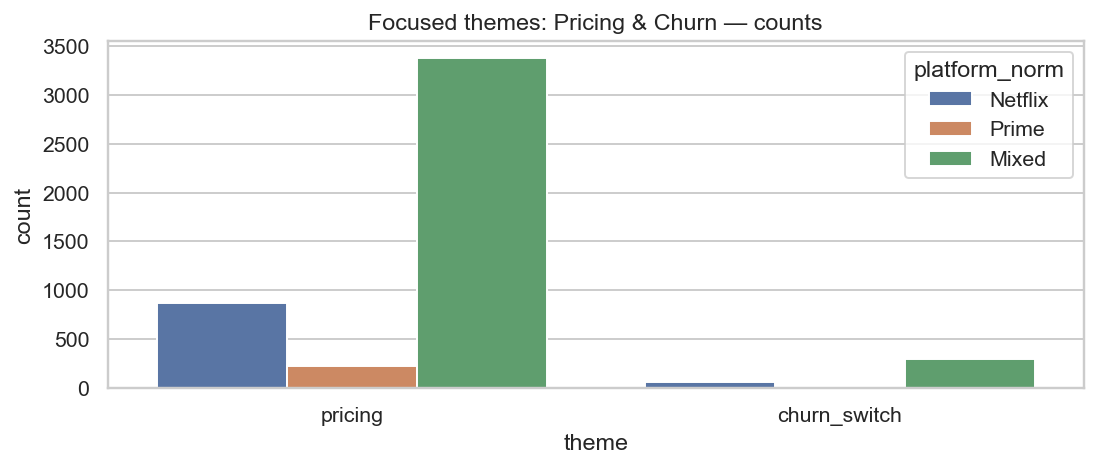

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/08_focus_pricing_churn_counts.png


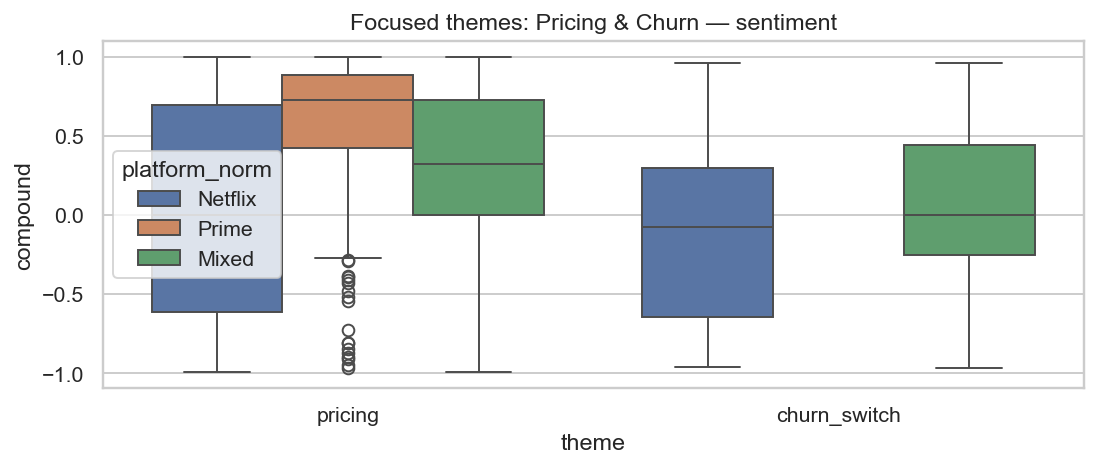

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/09_focus_pricing_churn_sentiment.png


In [ ]:

# Focused themes: pricing & churn
focus = mrk[mrk["theme"].isin(["pricing","churn_switch"])].copy()
if not focus.empty:
    plt.figure(figsize=(8,3.5))
    sns.countplot(data=focus, x="theme", hue="platform_norm")
    plt.title("Focused themes: Pricing & Churn — counts")
    savefig("08_focus_pricing_churn_counts.png")

    # Sentiment for focused themes
    plt.figure(figsize=(8,3.5))
    sns.boxplot(data=focus, x="theme", y="compound", hue="platform_norm")
    plt.title("Focused themes: Pricing & Churn — sentiment")
    savefig("09_focus_pricing_churn_sentiment.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:44: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:45: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


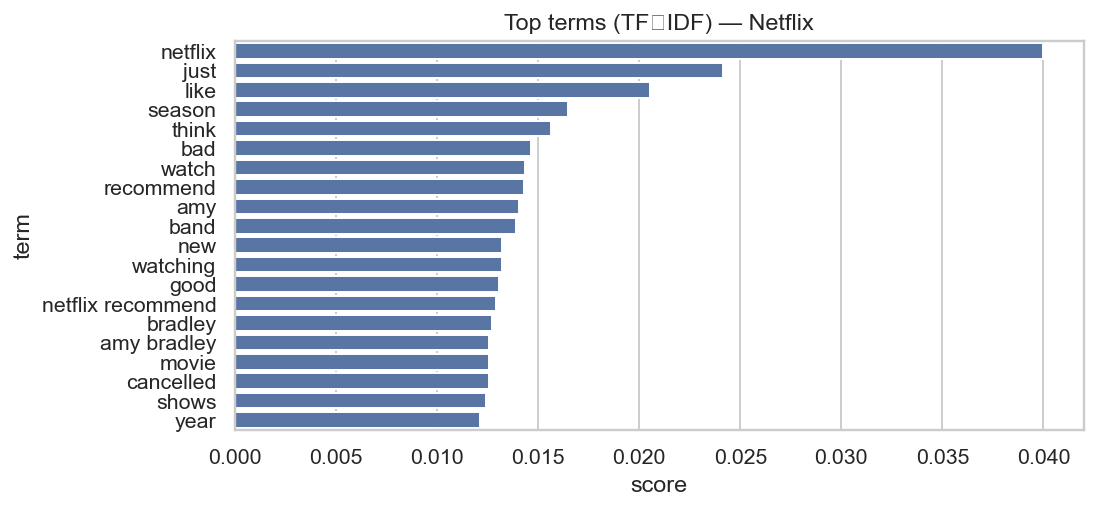

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/10_tfidf_top_terms_netflix.png


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:44: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_9309/3970078868.py:45: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


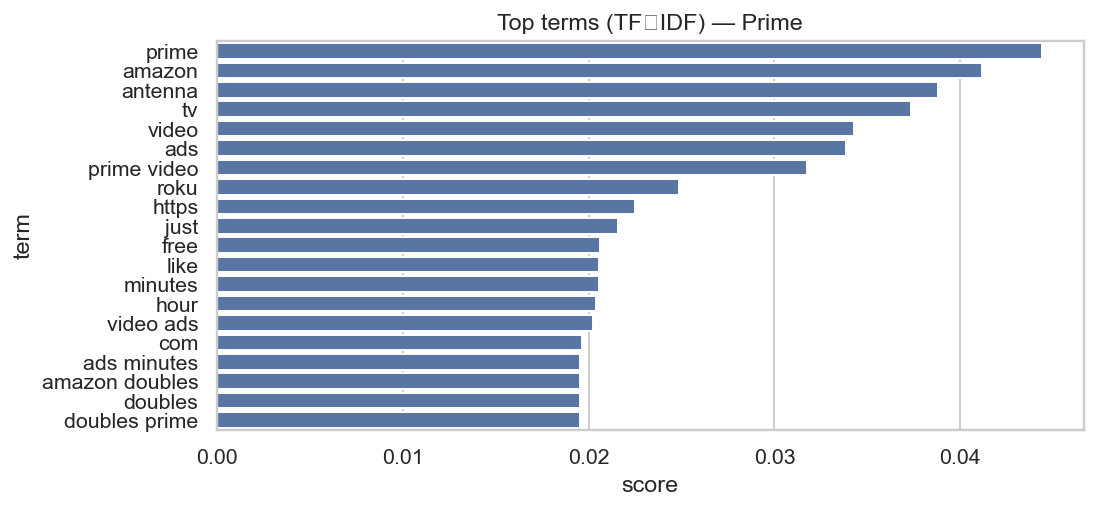

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/10_tfidf_top_terms_prime.png


In [ ]:
# TF‑IDF top terms (per platform, marketing‑relevant)
def top_terms(df, label, n=20):
    texts = df["text"].astype(str).tolist()
    if len(texts) < 10:
        print(f"[{label}] not enough texts for TF‑IDF.")
        return
    vec = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        min_df=3,
        stop_words="english"
    )
    X = vec.fit_transform(texts)
    scores = np.asarray(X.mean(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = scores.argsort()[::-1][:n]
    top = pd.DataFrame({"term": terms[idx], "score": scores[idx]})
    plt.figure(figsize=(8,3.8))
    sns.barplot(data=top, x="score", y="term")
    plt.title(f"Top terms (TF‑IDF) — {label}")
    savefig(f"10_tfidf_top_terms_{label.lower()}.png")

for label in ["Netflix","Prime"]:
    top_terms(mrk[mrk["platform_norm"]==label], label, n=20)

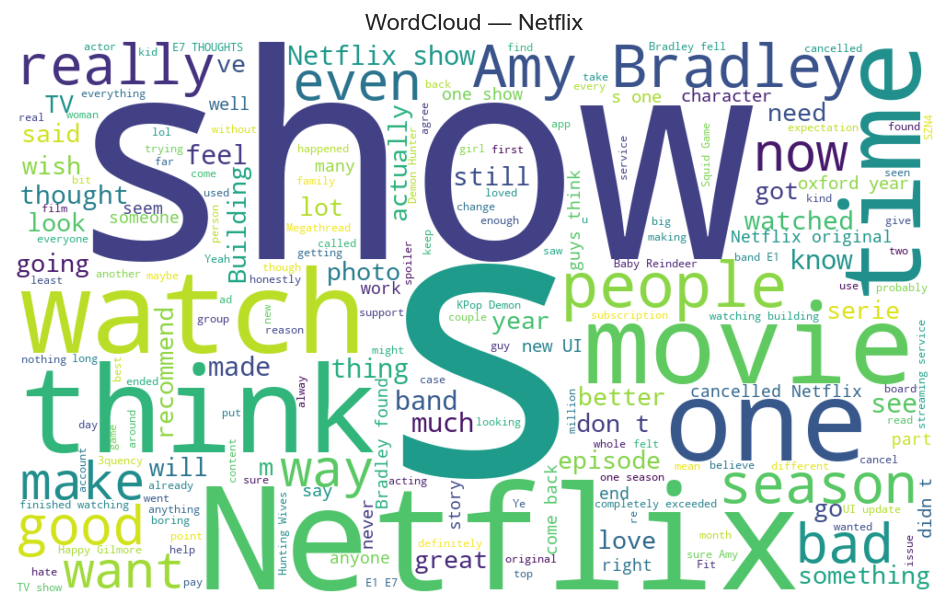

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/11_wordcloud_netflix.png


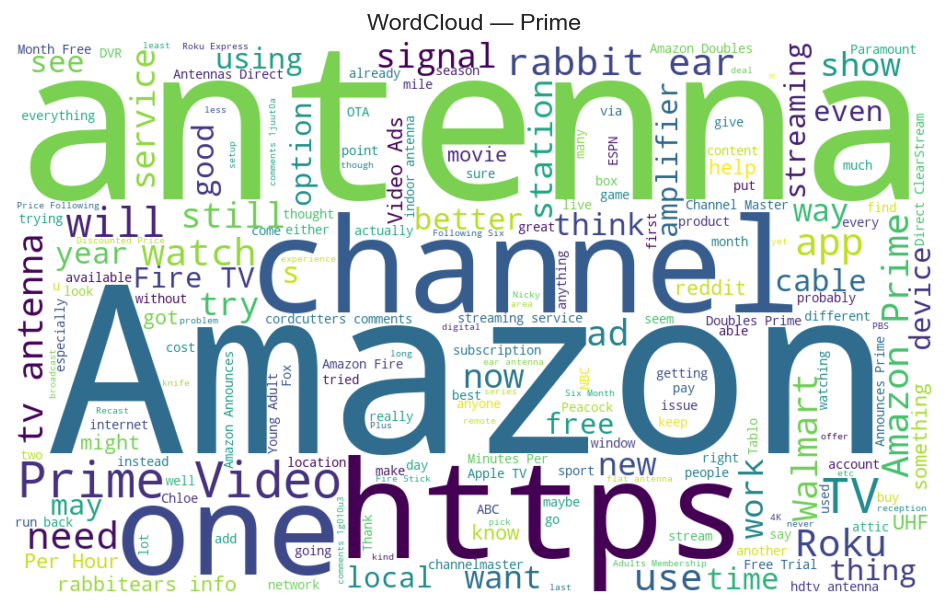

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/11_wordcloud_prime.png


In [ ]:
# Wordclouds
if WORDCLOUD_OK:
    for label in ["Netflix","Prime"]:
        text = " ".join(mrk[mrk["platform_norm"]==label]["text"].astype(str).tolist())
        if len(text) > 1000:
            wc = WordCloud(width=1000, height=600, background_color="white").generate(text)
            plt.figure(figsize=(8,4.5))
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"WordCloud — {label}")
            savefig(f"11_wordcloud_{label.lower()}.png")

In [ ]:
# 11) Export summary tables 
# counts by platform & theme
counts_tbl = theme_counts.sort_values(["platform_norm","count"], ascending=[True, False])
counts_tbl.to_csv(os.path.join(OUT_DIR, "summary_counts_by_platform_theme.csv"), index=False)

# average sentiment by platform & theme
sent_tbl = (mrk.groupby(["platform_norm","theme"])[["neg","neu","pos","compound"]]
            .mean().reset_index())
sent_tbl.to_csv(os.path.join(OUT_DIR, "summary_sentiment_by_platform_theme.csv"), index=False)

print("\nAll charts + CSVs saved to:", OUT_DIR)


All charts + CSVs saved to: /Users/saurabkohad/Downloads/reddit_marketing_outputs


# Industry Context Code

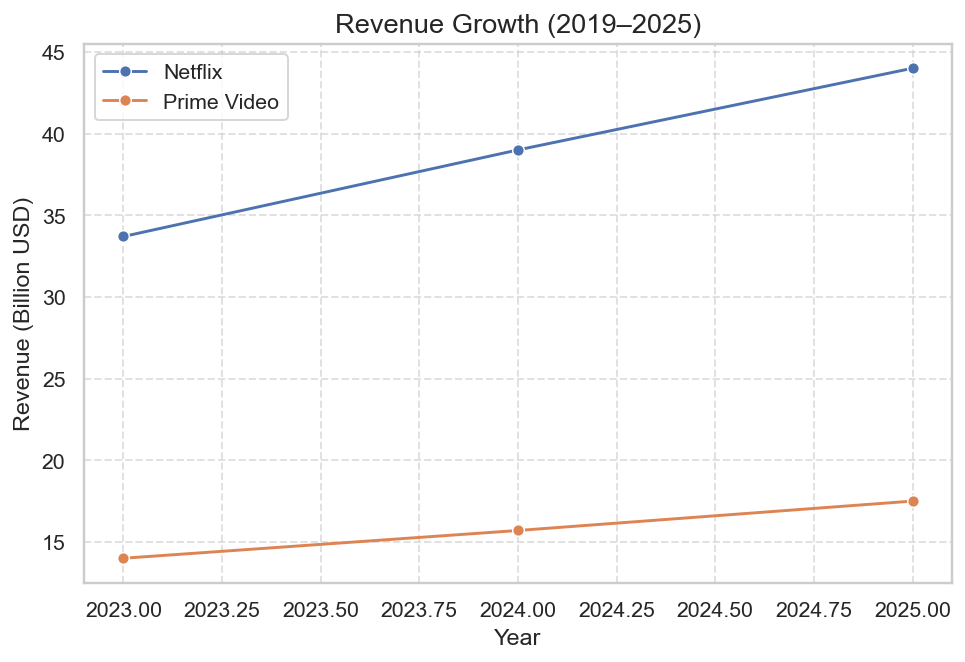

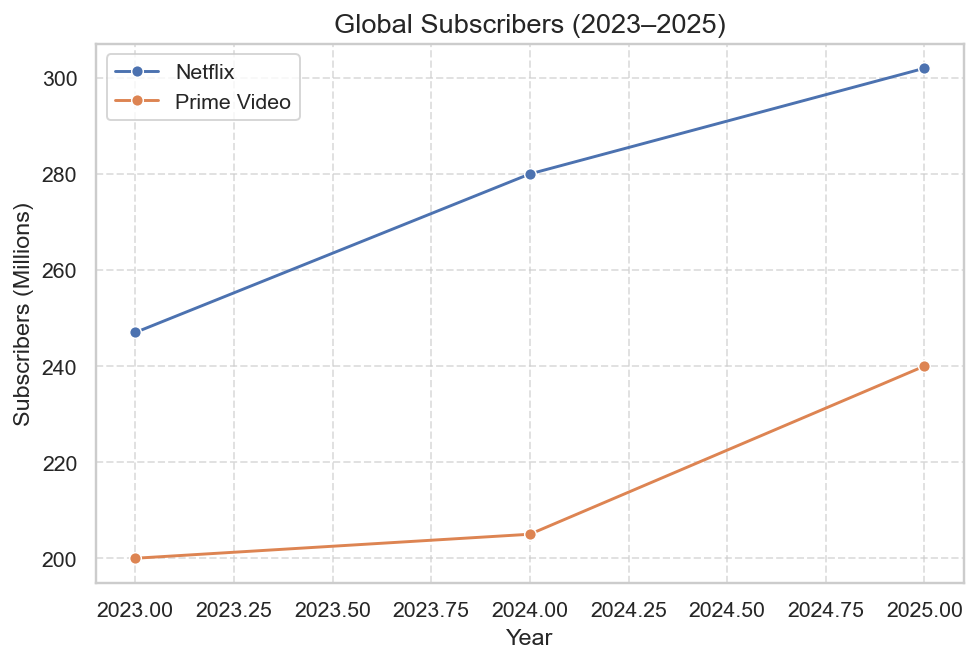

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/902149235.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_strategy, x="Platform", y="Adoption", palette="Set2")


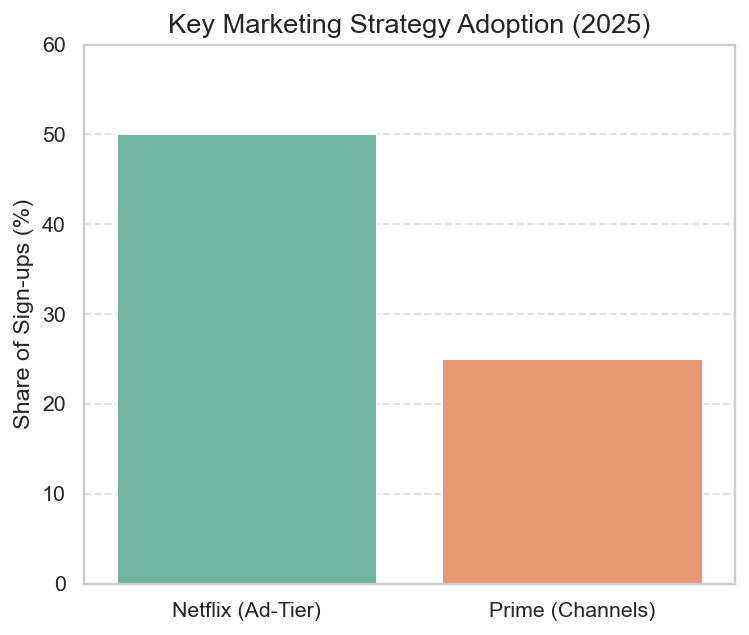

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# revenue and subscribers data for Netflix and Prime Video
revenue_data = {
    "Year": [2023, 2024, 2025],
    "Netflix": [33.7, 39.0, 44.0],  
    "Prime Video": [14.0, 15.7, 17.5] 
}
df_revenue = pd.DataFrame(revenue_data)


subscribers_data = {
    "Year": [2023, 2024, 2025],
    "Netflix": [247, 280, 302],  # known data + estimates
    "Prime Video": [200, 205, 240]  # includes bundled Prime subs
}
df_subs = pd.DataFrame(subscribers_data)

# revenue growth plot
plt.figure(figsize=(8,5))
sns.lineplot(data=df_revenue, x="Year", y="Netflix", marker="o", label="Netflix")
sns.lineplot(data=df_revenue, x="Year", y="Prime Video", marker="o", label="Prime Video")
plt.title("Revenue Growth (2019–2025)", fontsize=14)
plt.ylabel("Revenue (Billion USD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# subscriber growth plot
plt.figure(figsize=(8,5))
sns.lineplot(data=df_subs, x="Year", y="Netflix", marker="o", label="Netflix")
sns.lineplot(data=df_subs, x="Year", y="Prime Video", marker="o", label="Prime Video")
plt.title("Global Subscribers (2023–2025)", fontsize=14)
plt.ylabel("Subscribers (Millions)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# marketing strategy adoption rates
strategy_data = {
    "Platform": ["Netflix (Ad-Tier)", "Prime (Channels)"],
    "Adoption": [50, 25]  # % new signups attributed
}
df_strategy = pd.DataFrame(strategy_data)

plt.figure(figsize=(6,5))
sns.barplot(data=df_strategy, x="Platform", y="Adoption", palette="Set2")
plt.title("Key Marketing Strategy Adoption (2025)", fontsize=14)
plt.ylabel("Share of Sign-ups (%)")
plt.xlabel("")
plt.ylim(0, 60)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


Ratings shape: (25000095, 4)
Movies shape: (62423, 3)
Tags shape: (1093360, 4)

=== Ratings Head ===
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

=== Movies Head ===
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Unique users: 162541
Unique movies: 59047
Total 

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_1351/3765055110.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


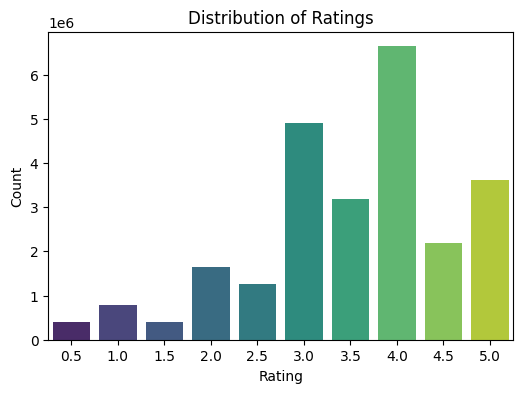

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_1351/3765055110.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="title", x="rating_count", data=top_movies, palette="mako")


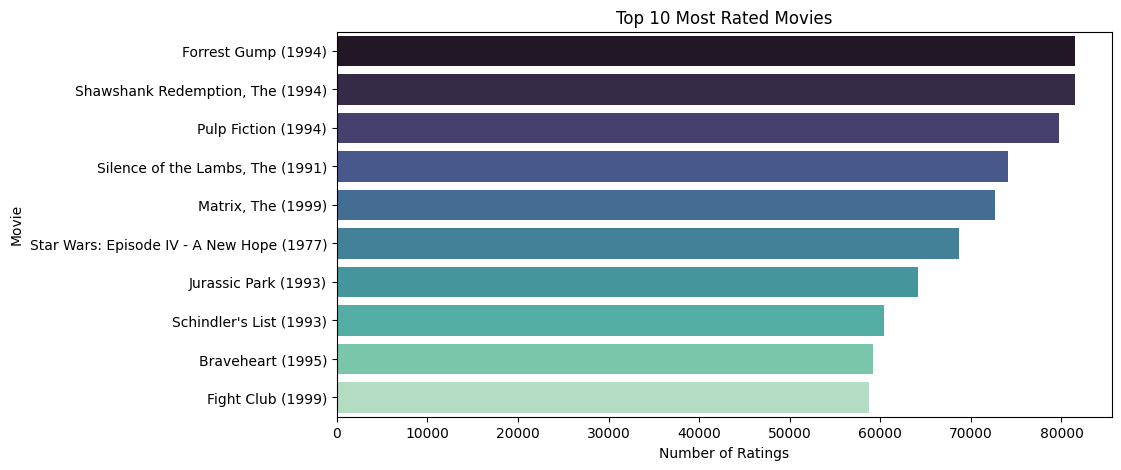

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Path to your unzipped MovieLens folder
path = "/Users/saurabkohad/Downloads/ml-25m"

# Load key files
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
movies = pd.read_csv(os.path.join(path, "movies.csv"))
tags = pd.read_csv(os.path.join(path, "tags.csv"))

# quick look
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)

print("\n=== Ratings Head ===")
print(ratings.head())

print("\n=== Movies Head ===")
print(movies.head())

# summary stats
print("\nUnique users:", ratings['userId'].nunique())
print("Unique movies:", ratings['movieId'].nunique())
print("Total ratings:", len(ratings))

# rating distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# top 10 most rated movies
top_movies = ratings['movieId'].value_counts().head(10).reset_index()
top_movies.columns = ['movieId','rating_count']
top_movies = top_movies.merge(movies, on='movieId')

plt.figure(figsize=(10,5))
sns.barplot(y="title", x="rating_count", data=top_movies, palette="mako")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie")
plt.show()



=== Ratings with datetime ===
   userId  movieId  rating   timestamp            datetime  year    month
0       1      296     5.0  1147880044 2006-05-17 15:34:04  2006  2006-05
1       1      306     3.5  1147868817 2006-05-17 12:26:57  2006  2006-05
2       1      307     5.0  1147868828 2006-05-17 12:27:08  2006  2006-05
3       1      665     5.0  1147878820 2006-05-17 15:13:40  2006  2006-05
4       1      899     3.5  1147868510 2006-05-17 12:21:50  2006  2006-05


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_2943/3798149178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


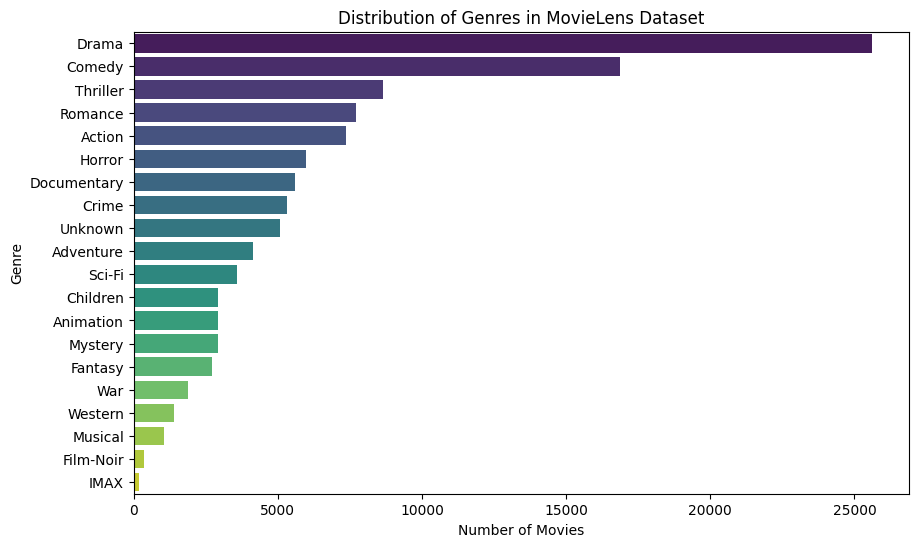


=== Genre one-hot encoded (sample) ===
         Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
movieId                                                                       
1             0          1          1         1       1      0            0   
2             0          1          0         1       0      0            0   
3             0          0          0         0       1      0            0   
4             0          0          0         0       1      0            0   
5             0          0          0         0       1      0            0   

         Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  \
movieId                                                                       
1            0        1          0       0     0        0        0        0   
2            0        1          0       0     0        0        0        0   
3            0        0          0       0     0        0        0        1   
4          

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_2943/3798149178.py:50: PerformanceWarning: The following operation may generate 9597558427 cells in the resulting pandas object.
  user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')



User–Item Matrix shape: (162541, 59047)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           3.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  209145  209147  209151  209153  209155  209157  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     

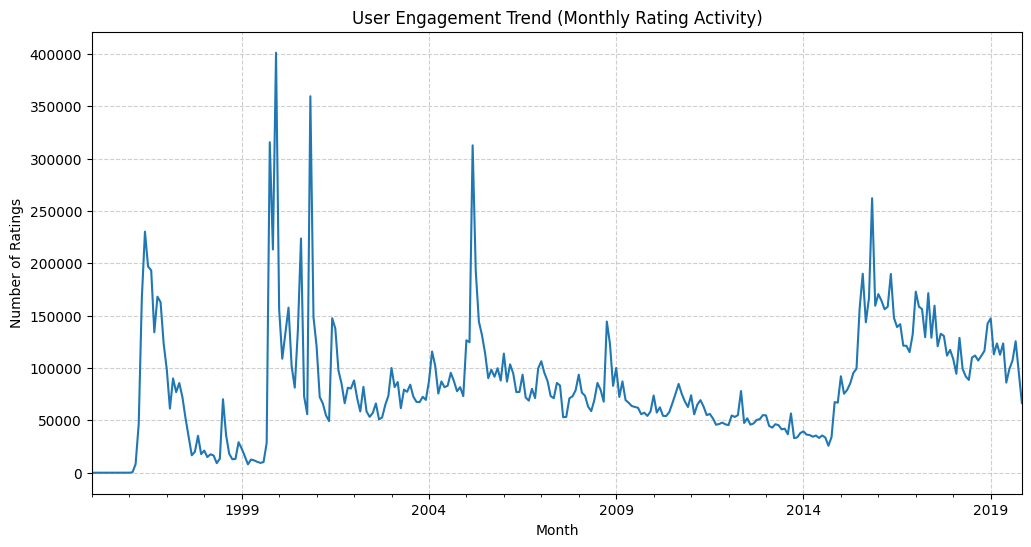

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer

# Path to dataset
path = "/Users/saurabkohad/Downloads/ml-25m"

# Load datasets
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
movies = pd.read_csv(os.path.join(path, "movies.csv"))

# convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.to_period('M')

print("\n=== Ratings with datetime ===")
print(ratings.head())

# genre processing
movies['genres'] = movies['genres'].replace('(no genres listed)', 'Unknown')
movies['genre_list'] = movies['genres'].apply(lambda x: x.split('|'))

# Flatten genre list for visualization
all_genres = [g for sublist in movies['genre_list'] for g in sublist]
genre_counts = pd.Series(all_genres).value_counts()

# Plot genre distribution
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Distribution of Genres in MovieLens Dataset")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

# one-hot encode genres
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    columns=mlb.classes_,
    index=movies['movieId']
)

print("\n=== Genre one-hot encoded (sample) ===")
print(genre_dummies.head())

# user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
print("\nUser–Item Matrix shape:", user_item_matrix.shape)
print(user_item_matrix.head(5))

# plot monthly rating activity
monthly_activity = ratings.groupby('month').size()

plt.figure(figsize=(12,6))
monthly_activity.plot()
plt.title("User Engagement Trend (Monthly Rating Activity)")
plt.xlabel("Month")
plt.ylabel("Number of Ratings")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



In [ ]:
# movielens recommender system from scratch
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# path to MovieLens dataset
ML_PATH = "/Users/saurabkohad/Downloads/ml-25m"  # <- your path
RATINGS_CSV = os.path.join(ML_PATH, "ratings.csv")
MOVIES_CSV  = os.path.join(ML_PATH, "movies.csv")

# load data
ratings = pd.read_csv(RATINGS_CSV)
movies  = pd.read_csv(MOVIES_CSV)

# subset to active users (>= 50 ratings)
min_ratings_per_user = 50
users_keep = ratings.groupby("userId").size().loc[lambda s: s >= min_ratings_per_user].index
ratings_filt = ratings[ratings.userId.isin(users_keep)]

# sample users if too many
target_users = 15000
if ratings_filt["userId"].nunique() > target_users:
    sampled_users = pd.Series(users_keep).sample(target_users, random_state=42).values
    ratings_filt = ratings_filt[ratings_filt.userId.isin(sampled_users)]

print("Users:", ratings_filt.userId.nunique(),
      "| Movies:", ratings_filt.movieId.nunique(),
      "| Ratings:", len(ratings_filt))

# timewise train-test split (last interaction per user for test)
ratings_filt = ratings_filt.sort_values(["userId", "timestamp"])
last_idx = ratings_filt.groupby("userId").tail(1).index  # one held-out interaction per user
test = ratings_filt.loc[last_idx]
train = ratings_filt.drop(index=last_idx)

print("Train size:", len(train), "| Test size:", len(test))

# build sparse user–item matrix
user_ids = np.sort(train.userId.unique())
movie_ids = np.sort(train.movieId.unique())

user_to_idx  = {int(u): int(i) for i, u in enumerate(user_ids)}
movie_to_idx = {int(m): int(i) for i, m in enumerate(movie_ids)}
idx_to_user  = {i: u for u, i in user_to_idx.items()}

rows = train.userId.map(user_to_idx).astype(np.int64).values
cols = train.movieId.map(movie_to_idx).astype(np.int64).values
data = train.rating.values.astype(np.float32)

R = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print("User–Item matrix shape:", R.shape)

# mean-center ratings by user
def user_means_from_sparse(R):
    sums = np.array(R.sum(axis=1)).ravel()
    counts = np.diff(R.indptr)
    means = np.divide(sums, counts, out=np.zeros_like(sums, dtype=float), where=counts!=0)
    return means

user_means = user_means_from_sparse(R)

R_centered = R.copy().astype(np.float32)
for u in range(R_centered.shape[0]):
    start, end = R_centered.indptr[u], R_centered.indptr[u+1]
    if start != end:
        R_centered.data[start:end] -= user_means[u]

# compute user–user cosine similarity matrix
# NOTE: dense_output=False gives a sparse matrix — we handle slices carefully below.
sim_users = cosine_similarity(R_centered, dense_output=False)
print("Similarity matrix computed.")

# prepare CSC versions for fast column slicing
R_csc = R.tocsc()
R_centered_csc = R_centered.tocsc()

def _to_1d_array(x):
    """Ensure we have a dense 1‑D numpy array."""
    if issparse(x):
        return x.toarray().ravel()
    x = np.asarray(x)
    return x.ravel()

def predict_user_item(u_idx, i_idx, K=40, min_sim=0.0):
    """Predict rating for user-index u_idx on item-index i_idx using top-K similar neighbours."""
    # force plain Python ints
    try:
        u_idx = int(u_idx); i_idx = int(i_idx)
    except Exception:
        return np.nan

    # bounds guard
    if not (0 <= u_idx < R.shape[0]) or not (0 <= i_idx < R.shape[1]):
        return np.nan

    # users who rated item i (column slice in CSC)
    start, end = R_csc.indptr[i_idx], R_csc.indptr[i_idx+1]
    raters = R_csc.indices[start:end]  # user indices who rated i
    if len(raters) == 0:
        return float(user_means[u_idx])  # fallback to user mean

    # similarities between target user and raters  
    sims = sim_users[u_idx, raters]
    sims = _to_1d_array(sims)

    # threshold + top-K by absolute similarity
    if sims.size == 0:
        return float(user_means[u_idx])
    mask = sims > float(min_sim)
    raters = raters[mask]
    sims   = sims[mask]
    if sims.size == 0:
        return float(user_means[u_idx])

    # top-K neighbours
    topk = np.argsort(-np.abs(sims))[:K]
    nbrs = raters[topk]
    nbr_sims = sims[topk]

    # neighbour centered ratings for this item
    cstart, cend = R_centered_csc.indptr[i_idx], R_centered_csc.indptr[i_idx+1]
    raters_c = R_centered_csc.indices[cstart:cend]
    vals_c   = R_centered_csc.data[cstart:cend]
    if len(raters_c) == 0:
        return float(user_means[u_idx])

    # map neighbour -> centered rating
    val_map = {int(u): float(v) for u, v in zip(raters_c, vals_c)}
    nbr_vals = np.array([val_map.get(int(n), np.nan) for n in nbrs], dtype=np.float32)
    keep = ~np.isnan(nbr_vals)
    if keep.sum() == 0:
        return float(user_means[u_idx])

    nbr_vals = nbr_vals[keep]
    nbr_sims = nbr_sims[keep]

    denom = np.sum(np.abs(nbr_sims))
    if denom == 0:
        return float(user_means[u_idx])

    pred_centered = np.sum(nbr_sims * nbr_vals) / denom
    return float(user_means[u_idx] + pred_centered)

# evaluate on test set
test_eval = test[test.movieId.isin(movie_ids)].copy()
if test_eval.empty:
    print("No test items are in the training set after subsetting. Increase sample size or relax filtering.")
else:
    # map to indices; drop missing; cast to int64
    test_eval["u_idx"] = test_eval.userId.map(user_to_idx)
    test_eval["i_idx"] = test_eval.movieId.map(movie_to_idx)
    test_eval = test_eval.dropna(subset=["u_idx","i_idx"]).copy()
    test_eval["u_idx"] = test_eval["u_idx"].astype(np.int64)
    test_eval["i_idx"] = test_eval["i_idx"].astype(np.int64)

    # sample for speed if too large
    # if len(test_eval) > 5000:
    #     test_eval = test_eval.sample(5000, random_state=42)

    preds = []
    for _, row in test_eval.iterrows():
        preds.append(predict_user_item(int(row.u_idx), int(row.i_idx), K=40, min_sim=0.0))

    preds = np.array(preds, dtype=float)
    mask = ~np.isnan(preds)
    rmse = sqrt(mean_squared_error(test_eval.loc[mask, "rating"].values, preds[mask]))
    print(f"User–User CF RMSE (1‑held‑out per user): {rmse:.4f}")

# recommendation function
def recommend_for_user(target_user_id, N=10, K=40, min_sim=0.0, sample_candidates=5000):
    """Return top‑N recommendations for a training user."""
    if int(target_user_id) not in user_to_idx:
        raise ValueError("User not in training subset. Pick a user from 'user_ids'.")
    u_idx = int(user_to_idx[int(target_user_id)])

    # candidate items = movies in train the user hasn't rated
    user_row = R.getrow(u_idx)
    rated_items = set(user_row.indices.tolist())
    candidates = np.setdiff1d(np.arange(R.shape[1], dtype=np.int64),
                              np.fromiter(rated_items, dtype=np.int64, count=len(rated_items)))

    # optional sampling for speed
    if sample_candidates and len(candidates) > sample_candidates:
        candidates = np.random.choice(candidates, size=sample_candidates, replace=False)

    scores = []
    for i_idx in candidates:
        pred = predict_user_item(u_idx, int(i_idx), K=K, min_sim=min_sim)
        scores.append((int(i_idx), float(pred)))
    if not scores:
        return pd.DataFrame(columns=["movieId","title","pred_rating"])

    scores = sorted(scores, key=lambda x: x[1], reverse=True)[:N]
    out = pd.DataFrame(scores, columns=["i_idx","pred_rating"])
    inv_movie_map = {v:k for k,v in movie_to_idx.items()}
    out["movieId"] = out["i_idx"].map(inv_movie_map).astype(int)
    out = out.merge(movies, on="movieId", how="left")[["movieId","title","pred_rating"]]
    return out

# example recommendation
example_user = int(np.random.choice(user_ids, 1)[0])
print("\nExample user:", example_user)
recs = recommend_for_user(example_user, N=10, K=40)
print("\nTop‑N recommendations:")
print(recs)



Users: 15000 | Movies: 34368 | Ratings: 3411774
Train size: 3396774 | Test size: 15000
User–Item matrix shape: (15000, 34319)
Similarity matrix computed.
User–User CF RMSE (1‑held‑out per user): 0.8970

Example user: 147485

Top‑N recommendations:
   movieId                                              title  pred_rating
0   138580                               I Can See You (2008)     6.323297
1   203170  Secrets in the Sky: The Untold Story of Skunk ...     5.975551
2   138172                                    Baseline (2010)     5.827577
3   200930                          C'est quoi la vie? (1999)     5.597088
4     7356                              Night Crossing (1981)     5.566342
5   132333                                        Seve (2014)     5.516608
6   171297                   Doug Stanhope: No Refunds (2007)     5.416168
7   187847                  Neat: The Story of Bourbon (2018)     5.416168
8   196695             All the Creatures Were Stirring (2018)     5.416168
9 

Users: 15000 | Movies: 34368 | Ratings: 3411774
Train size: 3396774 | Test size: 15000
User–Item matrix shape: (15000, 34319)


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


SVD explained variance ratio sum (k=80, n_iter=10): 0.231
TruncatedSVD RMSE (1‑held‑out per user): 0.9535

Example user: 160219
Top‑N (SVD):
   movieId                                   title       est
0      745  Wallace & Gromit: A Close Shave (1995)  4.332014
1     1729                     Jackie Brown (1997)  4.323750
2     5679                        Ring, The (2002)  4.219610
3     1231                 Right Stuff, The (1983)  4.196985
4     1409                          Michael (1996)  4.193154
5     2761                  Iron Giant, The (1999)  4.188432
6    30707              Million Dollar Baby (2004)  4.184416
7     2321                    Pleasantville (1998)  4.180809
8     4368                   Dr. Dolittle 2 (2001)  4.176894
9   115569                     Nightcrawler (2014)  4.174235

Catalog Coverage (Top‑10 over 1000 users): 5.71%
Genre Diversity — mean entropy across users: 3.303 bits


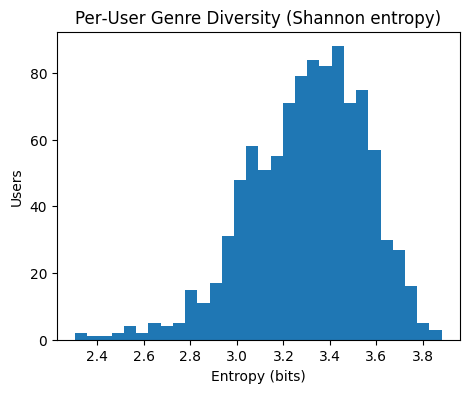

Novelty — mean long‑tail share in Top‑10: 0.07%


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter= 7 -> RMSE=0.9544, EVR=0.169, time=0.8s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter=10 -> RMSE=0.9544, EVR=0.170, time=1.2s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter=15 -> RMSE=0.9544, EVR=0.170, time=1.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter= 7 -> RMSE=0.9539, EVR=0.202, time=1.2s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter=10 -> RMSE=0.9539, EVR=0.203, time=1.6s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter=15 -> RMSE=0.9541, EVR=0.203, time=2.1s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter= 7 -> RMSE=0.9537, EVR=0.230, time=1.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter=10 -> RMSE=0.9535, EVR=0.231, time=2.0s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter=15 -> RMSE=0.9537, EVR=0.231, time=3.0s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter= 7 -> RMSE=0.9543, EVR=0.255, time=1.8s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter=10 -> RMSE=0.9542, EVR=0.256, time=2.4s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter=15 -> RMSE=0.9541, EVR=0.256, time=3.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=120, n_iter= 7 -> RMSE=0.9537, EVR=0.278, time=1.9s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=120, n_iter=10 -> RMSE=0.9538, EVR=0.279, time=2.7s
k=120, n_iter=15 -> RMSE=0.9537, EVR=0.279, time=3.5s

SVD hyperparameter results (sorted):
      k  n_iter      RMSE   ExplVar  TrainTimeSec
7    80      10  0.953548  0.230746      1.950312
12  120       7  0.953674  0.278441      1.945940
8    80      15  0.953683  0.231015      2.979607
6    80       7  0.953704  0.230155      1.466857
14  120      15  0.953734  0.279495      3.545807
13  120      10  0.953800  0.279152      2.745659
3    60       7  0.953920  0.202034      1.173817
4    60      10  0.953933  0.202507      1.641599
5    60      15  0.954055  0.202729      2.147697
11  100      15  0.954130  0.256400      3.537054


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


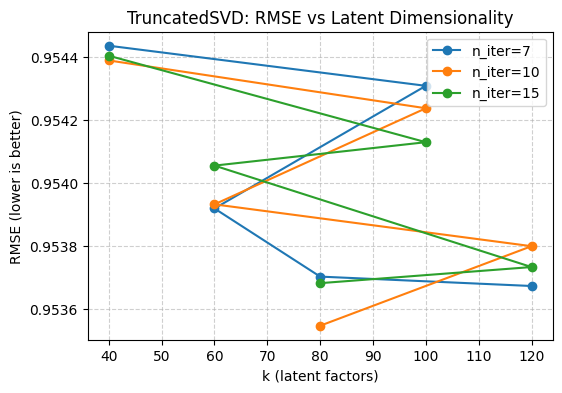

In [ ]:
# MovieLens TruncatedSVD recommender system from scratch

import os, time, numpy as np, pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from collections import Counter

# path to MovieLens dataset
ML_PATH = "/Users/saurabkohad/Downloads/ml-25m"   # <- your path
RATINGS_CSV = os.path.join(ML_PATH, "ratings.csv")
MOVIES_CSV  = os.path.join(ML_PATH, "movies.csv")

# load data
ratings = pd.read_csv(RATINGS_CSV)
movies  = pd.read_csv(MOVIES_CSV)

# filter to active users (>= 50 ratings)
min_ratings_per_user = 50
users_keep = ratings.groupby("userId").size().loc[lambda s: s >= min_ratings_per_user].index
ratings_filt = ratings[ratings.userId.isin(users_keep)].copy()

target_users = 15000  
if ratings_filt["userId"].nunique() > target_users:
    sampled_users = pd.Series(users_keep).sample(target_users, random_state=42).values
    ratings_filt = ratings_filt[ratings_filt.userId.isin(sampled_users)].copy()

print("Users:", ratings_filt.userId.nunique(),
      "| Movies:", ratings_filt.movieId.nunique(),
      "| Ratings:", len(ratings_filt))

# timewise train-test split (last interaction per user for test)
ratings_filt.sort_values(["userId","timestamp"], inplace=True)
test_idx = ratings_filt.groupby("userId").tail(1).index
test_df  = ratings_filt.loc[test_idx].copy()
train_df = ratings_filt.drop(index=test_idx).copy()
print("Train size:", len(train_df), "| Test size:", len(test_df))

# build sparse user–item matrix
user_ids = np.sort(train_df.userId.unique())
movie_ids = np.sort(train_df.movieId.unique())
user_to_idx  = {int(u): int(i) for i, u in enumerate(user_ids)}
movie_to_idx = {int(m): int(i) for i, m in enumerate(movie_ids)}

rows = train_df.userId.map(user_to_idx).astype(np.int64).values
cols = train_df.movieId.map(movie_to_idx).astype(np.int64).values
data = train_df.rating.values.astype(np.float32)
R = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print("User–Item matrix shape:", R.shape)

# mean-center ratings by user
def center_by_user(R):
    sums   = np.array(R.sum(axis=1)).ravel()
    counts = np.diff(R.indptr)
    means  = np.divide(sums, counts, out=np.zeros_like(sums, dtype=float), where=counts!=0)
    Rc = R.copy().astype(np.float32)
    for u in range(Rc.shape[0]):
        s, e = Rc.indptr[u], Rc.indptr[u+1]
        if s != e:
            Rc.data[s:e] -= means[u]
    return Rc, means

R_centered, user_means = center_by_user(R)

# tuncate SVD
k = 80
n_iter = 10
svd = TruncatedSVD(n_components=k, n_iter=n_iter, random_state=42)
Uk = svd.fit_transform(R_centered)           # (n_users, k)
Vk = svd.components_.T.astype(np.float32)    # (n_items, k)
evr = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance ratio sum (k={k}, n_iter={n_iter}): {evr:.3f}")

# prediction function
def predict(u_idx: int, i_idx: int) -> float:
    if not (0 <= u_idx < Uk.shape[0]) or not (0 <= i_idx < Vk.shape[0]):
        return np.nan
    return float(np.dot(Uk[u_idx], Vk[i_idx]) + user_means[u_idx])

# evaluate on test set
eval_df = test_df[test_df.userId.isin(user_to_idx) & test_df.movieId.isin(movie_to_idx)].copy()
eval_df["u_idx"] = eval_df.userId.map(user_to_idx).astype(np.int64)
eval_df["i_idx"] = eval_df.movieId.map(movie_to_idx).astype(np.int64)

# sample for speed if too large
# if len(eval_df) > 10000:
#     eval_df = eval_df.sample(10000, random_state=42)

preds = np.array([predict(int(u), int(i)) for u, i in zip(eval_df.u_idx, eval_df.i_idx)], dtype=float)
mask  = ~np.isnan(preds)
rmse  = sqrt(mean_squared_error(eval_df.loc[mask, "rating"].values, preds[mask]))
print(f"TruncatedSVD RMSE (1‑held‑out per user): {rmse:.4f}")

# top-N recommendation function
user_items_train = train_df.groupby("userId")["movieId"].apply(set).to_dict()
all_items = np.array(list(movie_ids), dtype=np.int64)

def recommend_for_user_svd(user_id: int, N=10, candidate_sample=2000):
    if user_id not in user_items_train:
        raise ValueError("User not in training subset.")
    u_idx = user_to_idx[int(user_id)]
    rated = user_items_train[user_id]
    candidates = np.setdiff1d(all_items, np.fromiter(rated, dtype=np.int64, count=len(rated)))
    if len(candidates) == 0:
        return pd.DataFrame(columns=["movieId","title","est"])
    if len(candidates) > candidate_sample:
        candidates = np.random.choice(candidates, size=candidate_sample, replace=False)

    i_idx_arr = np.array([movie_to_idx[int(i)] for i in candidates], dtype=np.int64)
    scores = Uk[u_idx].dot(Vk[i_idx_arr].T) + user_means[u_idx]
    top_idx = np.argsort(-scores)[:N]
    top_items = candidates[top_idx]
    top_scores = scores[top_idx]

    out = pd.DataFrame({"movieId": top_items.astype(int), "est": top_scores.astype(float)})
    out = out.merge(movies, on="movieId", how="left")[["movieId","title","est"]]
    return out

example_user = int(np.random.choice(list(user_items_train.keys()), 1)[0])
print("\nExample user:", example_user)
print("Top‑N (SVD):")
print(recommend_for_user_svd(example_user, N=10))

# Diversity metrics
# 1) Catalog coverage over a user sample
def topn_for_users(user_list, N=10):
    seen = set(); rows = []
    for uid in user_list:
        try:
            recs = recommend_for_user_svd(int(uid), N=N)
            for _, r in recs.iterrows():
                seen.add(int(r.movieId))
                rows.append((int(uid), int(r.movieId), float(r.est)))
        except Exception:
            continue
    return seen, pd.DataFrame(rows, columns=["userId","movieId","est"])

sample_users = np.random.choice(list(user_items_train.keys()), size=min(1000, len(user_items_train)), replace=False)
covered, rec_matrix = topn_for_users(sample_users, N=10)
catalog_coverage = 100.0 * len(covered) / len(movie_ids)
print(f"\nCatalog Coverage (Top‑10 over {len(sample_users)} users): {catalog_coverage:.2f}%")

# 2) Genre diversity (Shannon entropy per user’s Top‑N)
movies_proc = movies.copy()
movies_proc["genres"] = movies_proc["genres"].replace("(no genres listed)", "Unknown")
movies_proc["genre_list"] = movies_proc["genres"].apply(lambda s: str(s).split("|"))
rec_matrix = rec_matrix.merge(movies_proc[["movieId","genre_list"]], on="movieId", how="left")

def shannon_entropy(counts: Counter) -> float:
    total = sum(counts.values())
    if total == 0: return 0.0
    ent = 0.0
    for c in counts.values():
        p = c/total
        ent += -p * np.log2(p + 1e-12)
    return ent

user_entropy = []
for uid, group in rec_matrix.groupby("userId"):
    genres = [g for lst in group["genre_list"].dropna().tolist() for g in lst]
    counts = Counter(genres)
    user_entropy.append(shannon_entropy(counts))
user_entropy = np.array(user_entropy, dtype=float)
print(f"Genre Diversity — mean entropy across users: {np.nanmean(user_entropy):.3f} bits")

plt.figure(figsize=(5.2,4))
plt.hist(user_entropy[~np.isnan(user_entropy)], bins=30)
plt.title("Per‑User Genre Diversity (Shannon entropy)")
plt.xlabel("Entropy (bits)"); plt.ylabel("Users")
plt.show()

# 3) Novelty (long‑tail share in Top‑N)
# Define "long‑tail" as items below a popularity percentile 
item_pop = train_df.groupby("movieId").size().rename("count").reset_index()
item_pop["rank"] = item_pop["count"].rank(method="first", ascending=False)
pct = 0.60  # bottom 60% = long tail
threshold_rank = item_pop["rank"].quantile(1 - pct)
longtail_items = set(item_pop.loc[item_pop["rank"] > threshold_rank, "movieId"].astype(int).tolist())

def novelty_share(rec_df):
    if rec_df.empty: return np.nan
    return np.mean(rec_df["movieId"].astype(int).isin(longtail_items))

novelty_scores = []
for uid in sample_users:
    try:
        recs = recommend_for_user_svd(int(uid), N=10)
        novelty_scores.append(novelty_share(recs))
    except:
        novelty_scores.append(np.nan)
novelty_scores = np.array(novelty_scores, dtype=float)
print(f"Novelty — mean long‑tail share in Top‑10: {np.nanmean(novelty_scores)*100:.2f}%")

# hyperparameter sweep for k and n_iter
def build_R_from_train(train_df, user_to_idx, movie_to_idx):
    rows = train_df.userId.map(user_to_idx).astype(np.int64).values
    cols = train_df.movieId.map(movie_to_idx).astype(np.int64).values
    data = train_df.rating.values.astype(np.float32)
    return csr_matrix((data, (rows, cols)), shape=(len(user_to_idx), len(movie_to_idx)))

def eval_svd_config(R_centered, user_means, eval_df, k, n_iter):
    t0 = time.time()
    svd = TruncatedSVD(n_components=k, n_iter=n_iter, random_state=42)
    Uk = svd.fit_transform(R_centered)
    Vk = svd.components_.T.astype(np.float32)
    evr = float(svd.explained_variance_ratio_.sum())

    u_idx = eval_df["u_idx"].values
    i_idx = eval_df["i_idx"].values
    preds = np.sum(Uk[u_idx] * Vk[i_idx], axis=1) + user_means[u_idx]
    rmse = sqrt(mean_squared_error(eval_df["rating"].values, preds))
    secs = time.time() - t0
    return rmse, evr, secs

# rebuild matrices for sweep to be explicit 
R = build_R_from_train(train_df, user_to_idx, movie_to_idx)
R_centered, user_means = center_by_user(R)
eval_df = test_df[test_df.userId.isin(user_to_idx) & test_df.movieId.isin(movie_to_idx)].copy()
eval_df["u_idx"] = eval_df.userId.map(user_to_idx).astype(np.int64)
eval_df["i_idx"] = eval_df.movieId.map(movie_to_idx).astype(np.int64)

grid = []
for k_try in [40, 60, 80, 100, 120]:
    for it_try in [7, 10, 15]:
        rmse_try, evr_try, secs_try = eval_svd_config(R_centered, user_means, eval_df, k_try, it_try)
        grid.append({"k": k_try, "n_iter": it_try, "RMSE": rmse_try, "ExplVar": evr_try, "TrainTimeSec": secs_try})
        print(f"k={k_try:3d}, n_iter={it_try:2d} -> RMSE={rmse_try:.4f}, EVR={evr_try:.3f}, time={secs_try:.1f}s")

svd_grid = pd.DataFrame(grid).sort_values(["RMSE","TrainTimeSec"], ascending=[True, True])
print("\nSVD hyperparameter results (sorted):")
print(svd_grid.head(10))

# Visual: RMSE vs k per n_iter
plt.figure(figsize=(6,4))
for it in sorted(svd_grid.n_iter.unique()):
    sub = svd_grid[svd_grid.n_iter == it]
    plt.plot(sub.k, sub.RMSE, marker="o", label=f"n_iter={it}")
plt.title("TruncatedSVD: RMSE vs Latent Dimensionality")
plt.xlabel("k (latent factors)")
plt.ylabel("RMSE (lower is better)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [ ]:
# MovieLens data loader (searches common locations)
import os, glob
import pandas as pd


BASE_HINT = "/Users/saurabkohad/Downloads"   # your Downloads root; the code will recurse within here

def first_hit(patterns, roots):
    for root in roots:
        for pat in patterns:
            hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
            if hits:
                return hits[0]
    return None

# check if already loaded in global namespace
ratings = globals().get("ratings", None)
movies  = globals().get("movies",  None)

if ratings is None or movies is None:
    # Candidate roots to search
    roots = [
        os.environ.get("MOVIELENS_DIR",""),
        BASE_HINT,
        os.path.expanduser("~/Downloads"),
        os.path.expanduser("~/Documents"),
        os.getcwd(),
    ]
    roots = [r for r in roots if r and os.path.isdir(r)]

    # search for key files
    ratings_path = first_hit(["ratings.csv", "ratings.dat", "u.data"], roots)
    movies_path  = first_hit(["movies.csv", "movies.dat", "u.item"], roots)

    if not ratings_path:
        raise FileNotFoundError(
            "Could not locate ratings.csv/ratings.dat or u.data.\n"
            "→ Set BASE_HINT (or env MOVIELENS_DIR) to your MovieLens folder (e.g., ~/Downloads/ml-latest-small)."
        )

    print(f"Found ratings: {ratings_path}")
    if ratings_path.endswith(".csv"):
        ratings = pd.read_csv(ratings_path, usecols=["userId","movieId","rating"])
    elif ratings_path.endswith(".dat"):
        ratings = pd.read_csv(
            ratings_path, sep="::", engine="python",
            names=["userId","movieId","rating","timestamp"],
            usecols=[0,1,2]
        )
    else:  # u.data
        ratings = pd.read_csv(
            ratings_path, sep="\t", header=None,
            names=["userId","movieId","rating","timestamp"],
            usecols=[0,1,2]
        )

    if movies is None:
        if not movies_path:
            print("Warning: movies file not found; plots will use movieId as labels.")
            movies = None
        else:
            print(f"Found movies:  {movies_path}")
            if movies_path.endswith(".csv"):
                movies = pd.read_csv(movies_path, usecols=["movieId","title"])
            elif movies_path.endswith(".dat"):
                movies = pd.read_csv(
                    movies_path, sep="::", engine="python",
                    names=["movieId","title","genres"],
                    usecols=[0,1]
                )
            else:  # u.item (pipe-delimited; latin-1 encoding)
                movies = pd.read_csv(
                    movies_path, sep="|", header=None, encoding="latin-1",
                    names=["movieId","title"] + [f"c{i}" for i in range(22)],
                    usecols=[0,1]
                )

print(f"ratings shape: {ratings.shape}")
print(f"movies  shape: {None if movies is None else movies.shape}")


Found ratings: /Users/saurabkohad/Downloads/ml-25m/ratings.csv
Found movies:  /Users/saurabkohad/Downloads/ml-25m/movies.csv
ratings shape: (25000095, 3)
movies  shape: (62423, 2)


Pass 1/3: counting user activity (chunked)…
Selected users: 8,000 (includes USER_ID=147485)
Pass 2/3: filtering ratings for kept users (chunked)…
Kept ratings: 2,579,687 | users: 8,000
After movie filter (≥100 ratings): users=8,000, movies=4,082, rows=2,253,691
CSR shape: (8000, 4082)
Scoring candidates…


100%|██████████| 4012/4012 [00:00<00:00, 11676.77it/s]



Top-N recommendations for USER_ID = 147485
   movieId                                       title  pred_score
0   170705                     Band of Brothers (2001)    4.380580
1   171011                      Planet Earth II (2016)    4.330781
2   159817                         Planet Earth (2006)    4.301866
3      326                     To Live (Huozhe) (1994)    4.262441
4   166024                             Whiplash (2013)    4.183505
5     3134  Grand Illusion (La grande illusion) (1937)    4.145405
6     3030                              Yojimbo (1961)    4.128591
7     3435                     Double Indemnity (1944)    4.121413
8      908                   North by Northwest (1959)    4.108245
9     6669                                Ikiru (1952)    4.104105


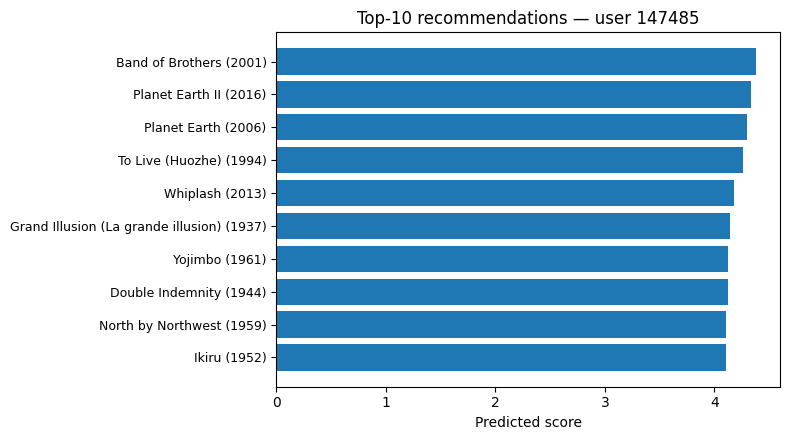

In [ ]:
# MovieLens recommender system from scratch (memory-efficient, chunked)
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from tqdm import tqdm

# path to MovieLens dataset
BASE_ML = "/Users/saurabkohad/Downloads/ml-25m"   # <- your path
RATINGS_CSV = os.path.join(BASE_ML, "ratings.csv")
MOVIES_CSV  = os.path.join(BASE_ML, "movies.csv")

USER_ID = 147485           # <- example user you used earlier
TARGET_USERS = 8000        # cap users to keep memory manageable
MIN_RATINGS_PER_USER = 100 # only keep users with >= this many ratings
MIN_RATINGS_PER_MOVIE = 100
TOP_N = 10
SAMPLE_CANDIDATES = 5000   # sample from candidate items to score faster
RANDOM_STATE = 42

# helper: mean per user from CSR
def user_means_from_sparse(R):
    # mean per user (row) for CSR
    sums = np.asarray(R.sum(axis=1)).ravel()
    counts = np.diff(R.indptr)
    means = np.divide(sums, counts, out=np.zeros_like(sums, dtype=float), where=counts!=0)
    return means

#pass 1: count user activity (chunked)
print("Pass 1/3: counting user activity (chunked)…")
user_counts = {}
chunksize = 2_000_000
for chunk in pd.read_csv(RATINGS_CSV, usecols=["userId","movieId","rating"], chunksize=chunksize):
    vc = chunk["userId"].value_counts()
    for uid, cnt in vc.items():
        user_counts[uid] = user_counts.get(uid, 0) + int(cnt)

# filter users
user_counts = pd.Series(user_counts).sort_values(ascending=False)
active_users = user_counts[user_counts >= MIN_RATINGS_PER_USER].index.tolist()

# ensure USER_ID is included
if USER_ID not in active_users:
    active_users.append(USER_ID)

# cap to TARGET_USERS, but keep USER_ID
rng = np.random.default_rng(RANDOM_STATE)
if len(active_users) > TARGET_USERS:
    pool = [u for u in active_users if u != USER_ID]
    take = TARGET_USERS - 1
    active_users = [USER_ID] + list(rng.choice(pool, size=take, replace=False))

print(f"Selected users: {len(active_users):,} (includes USER_ID={USER_ID})")

# pass 2: filter ratings for kept users (chunked)
print("Pass 2/3: filtering ratings for kept users (chunked)…")
keep_set = set(active_users)
parts = []
nrows = 0
for chunk in pd.read_csv(RATINGS_CSV, usecols=["userId","movieId","rating"], chunksize=chunksize):
    sub = chunk[chunk["userId"].isin(keep_set)]
    if not sub.empty:
        parts.append(sub)
        nrows += len(sub)

ratings_sub = pd.concat(parts, ignore_index=True)
print(f"Kept ratings: {len(ratings_sub):,} | users: {ratings_sub.userId.nunique():,}")

# filter movies by activity
movie_counts = ratings_sub["movieId"].value_counts()
good_movies = movie_counts[movie_counts >= MIN_RATINGS_PER_MOVIE].index
ratings_sub = ratings_sub[ratings_sub["movieId"].isin(good_movies)].copy()

n_users = ratings_sub["userId"].nunique()
n_movies = ratings_sub["movieId"].nunique()
print(f"After movie filter (≥{MIN_RATINGS_PER_MOVIE} ratings): users={n_users:,}, movies={n_movies:,}, rows={len(ratings_sub):,}")

# build csr matrix
u_index = pd.Index(sorted(ratings_sub["userId"].unique()))
i_index = pd.Index(sorted(ratings_sub["movieId"].unique()))
u_map = pd.Series(np.arange(len(u_index), dtype=np.int32), index=u_index)
i_map = pd.Series(np.arange(len(i_index), dtype=np.int32), index=i_index)

rows = ratings_sub["userId"].map(u_map).astype(np.int32).values
cols = ratings_sub["movieId"].map(i_map).astype(np.int32).values
vals = ratings_sub["rating"].astype(np.float32).values

R = csr_matrix((vals, (rows, cols)), shape=(len(u_index), len(i_index)))
print("CSR shape:", R.shape)

# center by user
user_means = user_means_from_sparse(R).astype(np.float32)
R_centered = R.copy().astype(np.float32)
for u in range(R_centered.shape[0]):
    start, end = R_centered.indptr[u], R_centered.indptr[u+1]
    if start != end:
        R_centered.data[start:end] -= user_means[u]

# Precompute CSC for column access
R_csc = R.tocsc()
R_centered_csc = R_centered.tocsc()

# prepare target user
if USER_ID not in u_map.index:
    raise ValueError(f"USER_ID {USER_ID} not in the sampled/filtered user set. Increase TARGET_USERS or adjust filters.")

u_idx = int(u_map.loc[USER_ID])

# target user centered row
u_vec = R_centered.getrow(u_idx)

# row (user) norms (SAFE replacement for .A1)
row_norms = np.sqrt(np.asarray(R_centered.multiply(R_centered).sum(axis=1)).ravel()) + 1e-8

# target user norm (SAFE replacement for .A1)
u_norm = float(np.sqrt(u_vec.multiply(u_vec).sum())) + 1e-8

# dot products with every user (SAFE replacement for .A1)
dots = R_centered.dot(u_vec.T).toarray().ravel()  # shape (U,)
sims = (dots / (row_norms * u_norm)).astype(np.float32)
sims[u_idx] = 0.0
sims[~np.isfinite(sims)] = 0.0

# score candidate items
rated_items = set(R.getrow(u_idx).indices.tolist())
all_items = np.arange(R.shape[1], dtype=np.int32)
candidates = np.setdiff1d(all_items, np.fromiter(rated_items, dtype=np.int32))

# optional sampling for speed
if SAMPLE_CANDIDATES and len(candidates) > SAMPLE_CANDIDATES:
    candidates = np.random.default_rng(RANDOM_STATE).choice(candidates, size=SAMPLE_CANDIDATES, replace=False)

def predict_for_item(i_idx, K=50, min_sim=0.0):
    # raters for this item (column slice of CSC)
    start, end = R_csc.indptr[i_idx], R_csc.indptr[i_idx+1]
    raters = R_csc.indices[start:end]
    if len(raters) == 0:
        return float(user_means[u_idx])  # fallback: user mean

    # similarities for these raters
    sim_vals = sims[raters]
    mask = sim_vals > min_sim
    raters = raters[mask]
    sim_vals = sim_vals[mask]
    if len(sim_vals) == 0:
        return float(user_means[u_idx])

    # take top-K by |sim|
    if len(sim_vals) > K:
        top = np.argpartition(-np.abs(sim_vals), K)[:K]
        raters = raters[top]
        sim_vals = sim_vals[top]

    # centered ratings for these raters on this item
    cstart, cend = R_centered_csc.indptr[i_idx], R_centered_csc.indptr[i_idx+1]
    r_users = R_centered_csc.indices[cstart:cend]
    r_vals  = R_centered_csc.data[cstart:cend]
    

    val_map = {int(u): float(v) for u, v in zip(r_users, r_vals)}
    nbr_vals = np.array([val_map.get(int(n), np.nan) for n in raters], dtype=np.float32)
    good = ~np.isnan(nbr_vals)
    if not np.any(good):
        return float(user_means[u_idx])

    nbr_vals = nbr_vals[good]
    sim_sel  = sim_vals[good]

    denom = np.sum(np.abs(sim_sel))
    if denom <= 0:
        return float(user_means[u_idx])

    pred_centered = float(np.sum(sim_sel * nbr_vals) / denom)
    return float(user_means[u_idx] + pred_centered)

print("Scoring candidates…")
scores = []
for i in tqdm(candidates, total=len(candidates)):
    s = predict_for_item(int(i), K=50, min_sim=0.0)
    scores.append((int(i), s))

# build top-N DataFrame
scores = sorted(scores, key=lambda x: x[1], reverse=True)[:TOP_N]
inv_i_index = pd.Series(i_index.values, index=np.arange(len(i_index)))  # col idx -> movieId
top_movieIds = inv_i_index.loc[[i for i,_ in scores]].astype(int).tolist()
top_scores   = [float(s) for _, s in scores]

movies = pd.read_csv(MOVIES_CSV, usecols=["movieId","title"])
movies["movieId"] = movies["movieId"].astype(int)
top_titles = (movies.set_index("movieId").reindex(top_movieIds)["title"]).tolist()

top_df = pd.DataFrame({
    "movieId": top_movieIds,
    "title": top_titles,
    "pred_score": top_scores
})

print("\nTop-N recommendations for USER_ID =", USER_ID)
print(top_df)

# visualize
plt.figure(figsize=(8, 4.5))
plt.barh(range(len(top_df)), top_df["pred_score"].values)
plt.yticks(range(len(top_df)), [t if len(str(t))<=60 else str(t)[:57]+"…" for t in top_df["title"]], fontsize=9)
plt.gca().invert_yaxis()
plt.xlabel("Predicted score")
plt.title(f"Top-{TOP_N} recommendations — user {USER_ID}")
plt.tight_layout()
plt.show()


# Focused Group Analysis

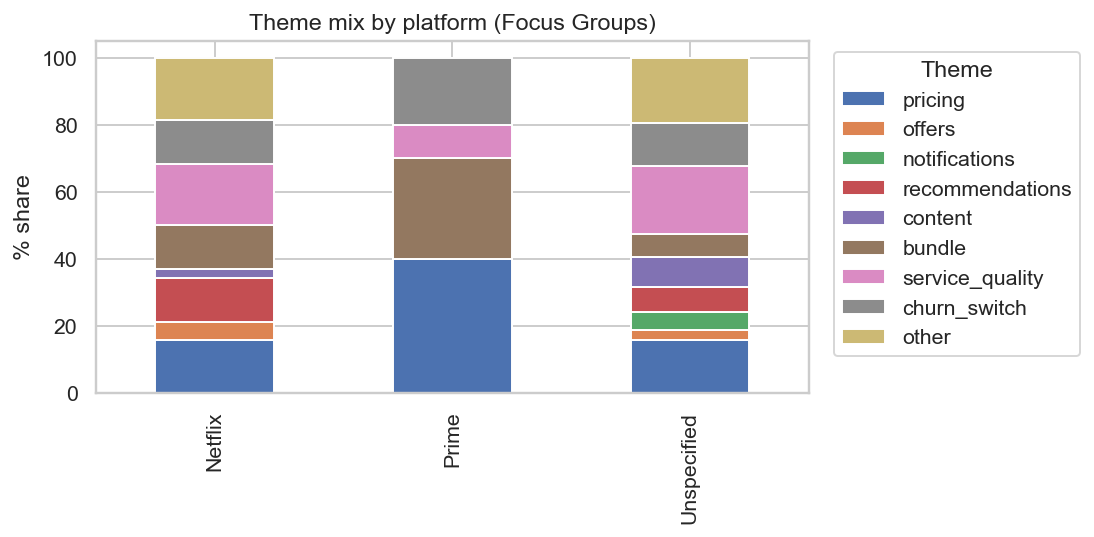

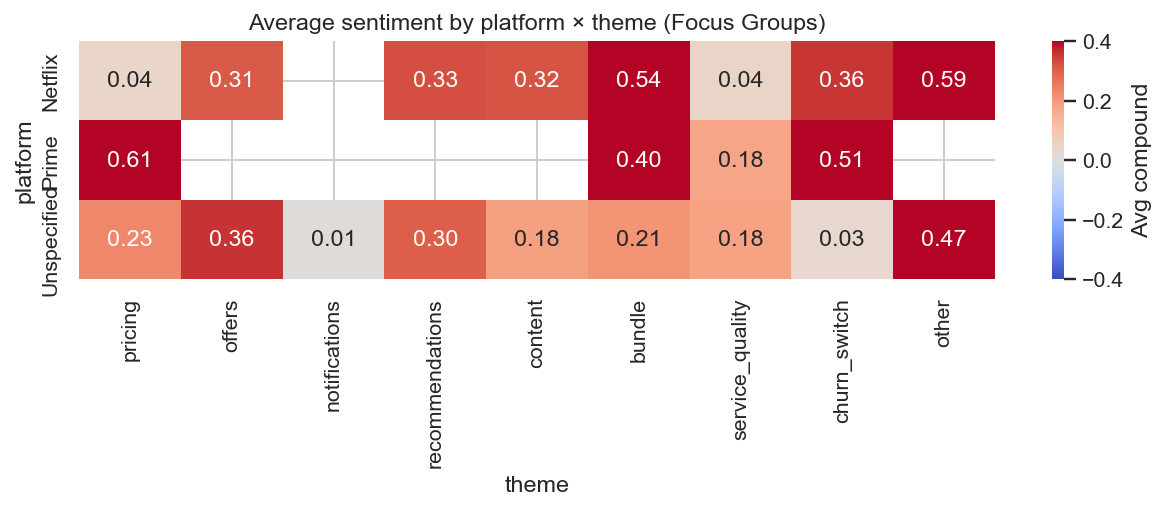

Saved outputs to: /Users/saurabkohad/Downloads/focus_groups_outputs
Rows parsed: 132 | Exploded theme rows: 181


In [ ]:
# Focus group transcript analysis (RTF to text, parse, anonymise, theme, sentiment)
import os, re, glob, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# path setup
BASE = "/Users/saurabkohad/Downloads"
IN_FILES = [
    os.path.join(BASE, "FG1.txt"),
    os.path.join(BASE, "FG2.txt"),
]
OUT_DIR = os.path.join(BASE, "focus_groups_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# minimal RTF to plain text converter
def rtf_to_text(s):
    if not s or not s.strip().startswith("{\\rtf"):
        return s
    # remove RTF control words and groups
    s = re.sub(r"\\'[0-9a-fA-F]{2}", " ", s)              # hex escapes
    s = re.sub(r"\\[a-zA-Z]+-?\d* ?|\\[{}\\]", " ", s)    # control words/symbols
    s = re.sub(r"[{}]", " ", s)                           # braces
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# read and parse a transcript file
def parse_transcript(path, group_id=None):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        raw = f.read()
    text = rtf_to_text(raw)

    # group id from filename if not provided (e.g., FG1.txt -> G1)
    if group_id is None:
        m = re.search(r"FG\s*([0-9]+)", os.path.basename(path), re.IGNORECASE)
        group_id = f"G{m.group(1)}" if m else "G?"

    rows = []
    # Split into lines and detect "Speaker: utterance"
    for line in re.split(r"\r?\n", text):
        line = line.strip()
        if not line:
            continue
        # Match "Label: text" at start of line
        m = re.match(r"^([^:]{1,60}):\s*(.+)$", line)
        if m:
            speaker, utt = m.group(1).strip(), m.group(2).strip()
        else:
            # If no speaker tag, attribute to "Unknown" (we can merge consecutive lines)
            speaker, utt = "Unknown", line
        rows.append((group_id, speaker, utt))
    # Collapse consecutive "Unknown" into a single chunk if desired (optional)
    return rows

# aggregate all transcripts
all_rows = []
for p in IN_FILES:
    if os.path.exists(p):
        all_rows.extend(parse_transcript(p))
    else:
        print("Missing file:", p)

df = pd.DataFrame(all_rows, columns=["group_id","speaker_raw","text"])
df = df[df["text"].str.len() > 0].copy()

# auto anonymise speakers within each group
anon_map = {}
def anon_name(g, s):
    key = (g, s.strip().lower())
    if key not in anon_map:
        idx = len([1 for (gg,_) in anon_map if gg==g]) + 1
        anon_map[key] = f"{g}_P{idx}"
    return anon_map[key]

df["speaker"] = df.apply(lambda r: anon_name(r["group_id"], r["speaker_raw"]), axis=1)

# detect platform mentions (Netflix, Prime, Unspecified)
def platform_from_text(t):
    t = str(t).lower()
    if "netflix" in t: return "Netflix"
    if ("prime video" in t) or ("primevideo" in t) or (" on prime" in t) or ("amazon" in t):
        return "Prime"
    return "Unspecified"
df["platform"] = df["text"].apply(platform_from_text)

# theme detection via keyword lexicon
THEME_LEXICON = {
    "pricing":        r"(price|pricing|hike|increase|cost|expensive|cheap|discount|student|trial|free trial|annual|monthly|bundle price)",
    "offers":         r"(offer|promo|promotion|deal|coupon|voucher|cashback|sale)",
    "notifications":  r"(notification|push|email|reminder|nudge|alert|pop[- ]?up)",
    "recommendations":r"(recommend|recommended|algorithm|algo|personaliz|suggestion|because you watched|autoplay|continue watching)",
    "content":        r"(originals?|exclusive|catalogue|catalog|library|new release|show|movie|series|season|sports)",
    "bundle":         r"(bundle|prime (benefits|shipping)|amazon|music|twitch|one[- ]?day|delivery|kindle)",
    "service_quality":r"(ui|ux|interface|app|buffer|lag|4k|hdr|ads?|ad[- ]?supported|login|account|payment)",
    "churn_switch":   r"(cancel|churn|quit|left|unsubscribe|switch|switched|moved to|drop(ped)?)"
}
THEME_REGEX = {k: re.compile(v, re.IGNORECASE) for k,v in THEME_LEXICON.items()}
theme_order = list(THEME_LEXICON.keys()) + ["other"]

def detect_themes(text):
    hits = [k for k, rx in THEME_REGEX.items() if rx.search(str(text))]
    return hits if hits else ["other"]

df["themes"] = df["text"].apply(detect_themes)
df_expl = df.explode("themes").rename(columns={"themes":"theme"})
df_expl["theme"] = df_expl["theme"].where(df_expl["theme"].isin(theme_order), "other")

# sentiment analysis (VADER)
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()
sent = df_expl["text"].apply(lambda t: sia.polarity_scores(t)).apply(pd.Series)
df_expl = pd.concat([df_expl, sent], axis=1)

# save outputs
df.to_csv(os.path.join(OUT_DIR, "focus_groups_raw_parsed.csv"), index=False)
df_expl.to_csv(os.path.join(OUT_DIR, "focus_groups_tidy_exploded.csv"), index=False)

# visualizations
sns.set(style="whitegrid"); plt.rcParams["figure.dpi"]=140

# A) Theme mix by platform (stacked %)
counts = (df_expl.groupby(["platform","theme"]).size()
          .reset_index(name="n"))
wide = counts.pivot(index="platform", columns="theme", values="n").fillna(0)
share = wide.div(wide.sum(axis=1), axis=0)*100
share = share.reindex(columns=theme_order, fill_value=0)

ax = share.plot(kind="bar", stacked=True, figsize=(8,4))
plt.title("Theme mix by platform (Focus Groups)")
plt.ylabel("% share"); plt.xlabel("")
plt.legend(title="Theme", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"FG_fig1_theme_mix.png")); plt.show()

# B) Average sentiment heatmap
sent_mean = (df_expl.groupby(["platform","theme"])["compound"].mean()
             .unstack().reindex(columns=theme_order))
plt.figure(figsize=(9,3.8))
sns.heatmap(sent_mean, annot=True, fmt=".2f", vmin=-0.4, vmax=0.4, cmap="coolwarm", cbar_kws={"label":"Avg compound"})
plt.title("Average sentiment by platform × theme (Focus Groups)")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"FG_fig2_sentiment_heatmap.png")); plt.show()

# C) Top exemplar quotes per theme/platform (for write-up)
def top_quotes(dfin, plat, theme, k=2):
    dfx = dfin[(dfin["platform"]==plat) & (dfin["theme"]==theme)].dropna(subset=["compound"])
    if dfx.empty: return pd.DataFrame()
    pos = dfx.sort_values("compound", ascending=False).head(k).assign(polarity="most_positive")
    neg = dfx.sort_values("compound", ascending=True).head(k).assign(polarity="most_negative")
    cols = ["group_id","speaker","platform","theme","compound","text"]
    return pd.concat([pos[cols+["polarity"]], neg[cols+["polarity"]]], ignore_index=True)

examples = []
for plat in ["Netflix","Prime","Unspecified"]:
    for t in theme_order:
        ex = top_quotes(df_expl, plat, t, k=2)
        if not ex.empty: examples.append(ex)
ex_all = pd.concat(examples, ignore_index=True) if examples else pd.DataFrame()
if not ex_all.empty:
    ex_all.to_csv(os.path.join(OUT_DIR, "FG_exemplar_quotes.csv"), index=False)

print("Saved outputs to:", OUT_DIR)
print("Rows parsed:", len(df), "| Exploded theme rows:", len(df_expl))


Tidy files saved in /Users/saurabkohad/Downloads/fg_outputs


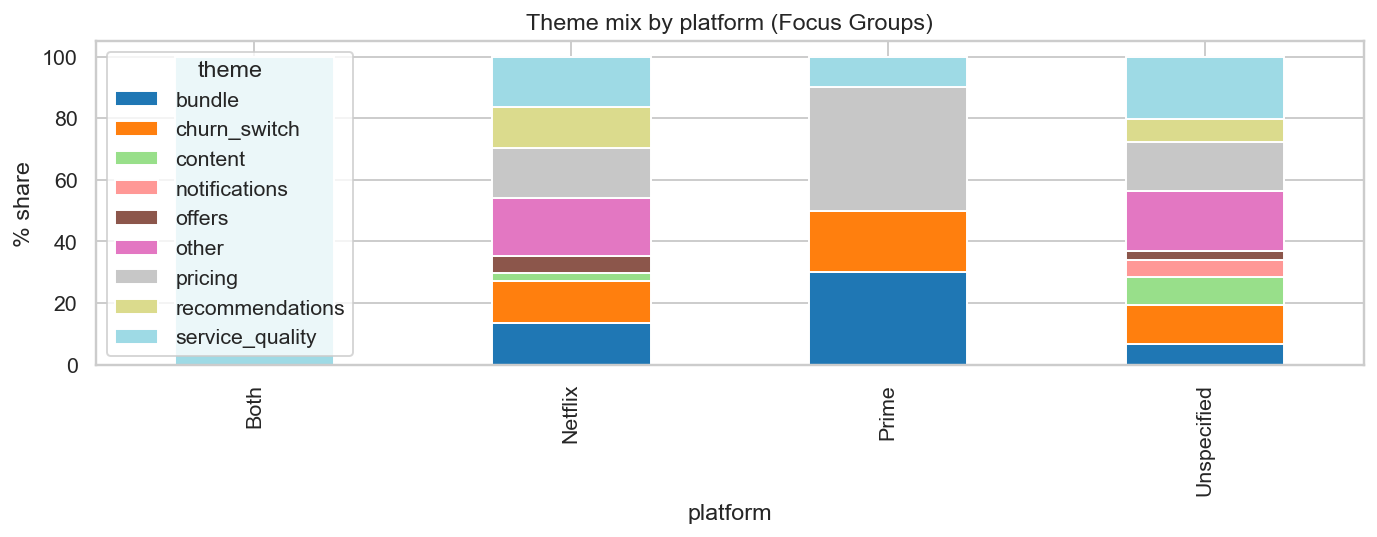

Saved: /Users/saurabkohad/Downloads/fg_outputs/FG_theme_mix_by_platform.png


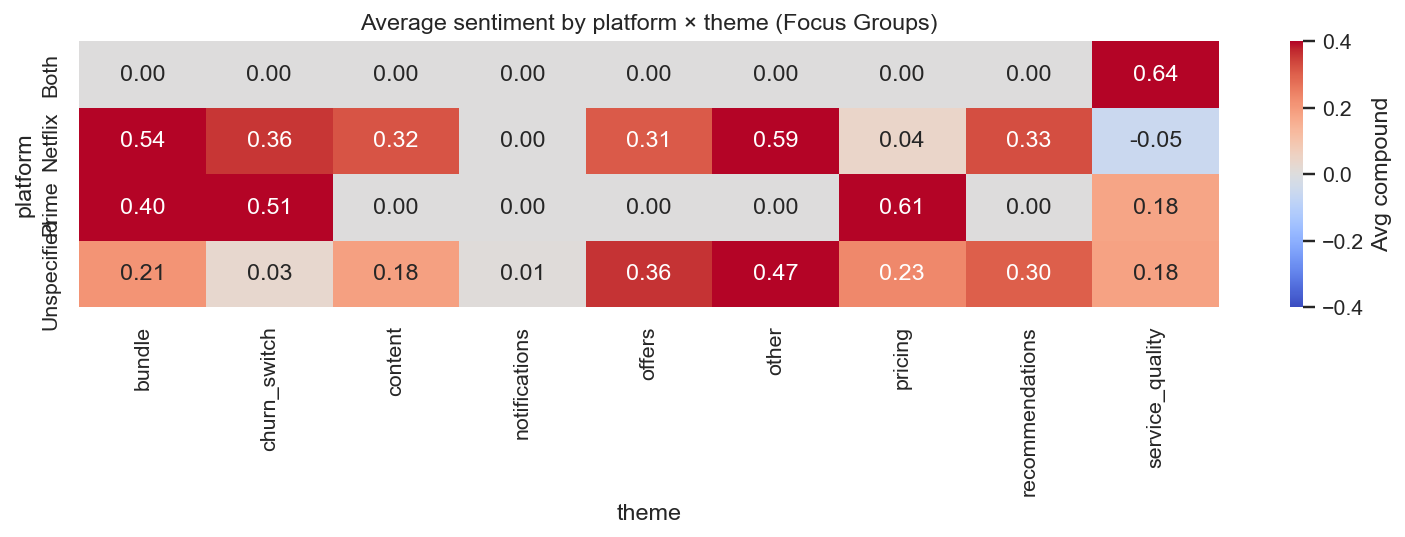

Saved: /Users/saurabkohad/Downloads/fg_outputs/FG_sentiment_heatmap.png


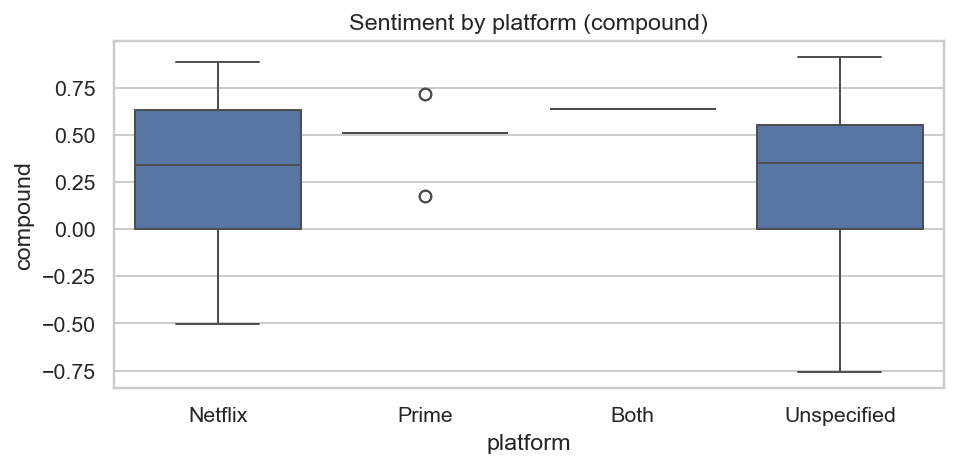

Saved: /Users/saurabkohad/Downloads/fg_outputs/FG_sentiment_by_platform_box.png
Chi-square theme mix (Netflix vs Prime): chi2=7.83, dof=7, p=0.3478
Mann–Whitney U (compound): U=135, p=0.1968  (n_N=37, n_P=10)

All charts & CSVs saved to: /Users/saurabkohad/Downloads/fg_outputs


In [ ]:
# Focus group transcript analysis (improved, with stats)
import os, re, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import chi2_contingency, mannwhitneyu

# path setup
BASE = "/Users/saurabkohad/Downloads"     # change if needed
FG_DIR = BASE
FG_FILES = ["FG1.txt", "FG2.txt"]
OUT_DIR = os.path.join(BASE, "fg_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# theme lexicon
THEME_LEXICON = {
    "pricing":        r"(price|pricing|hike|increase|cost|expensive|cheap|discount|student|trial|free trial|annual|monthly|bundle price)",
    "offers":         r"(offer|promo|promotion|deal|coupon|voucher|cashback|sale)",
    "notifications":  r"(notification|push|email|reminder|nudge|alert|pop[- ]?up)",
    "recommendations":r"(recommend|recommended|algorithm|algo|personaliz|suggestion|because you watched|autoplay|continue watching)",
    "content":        r"(originals?|exclusive|catalogue|catalog|library|new release|show|movie|series|season|sports)",
    "bundle":         r"(bundle|prime (benefits|shipping)|amazon|music|twitch|one[- ]?day|delivery|kindle)",
    "service_quality":r"(ui|ux|interface|app|buffer|lag|4k|hdr|ads?|ad[- ]?supported|login|account|payment)",
    "churn_switch":   r"(cancel|churn|quit|left|unsubscribe|switch|switched|moved to|drop(ped)?)"
}
THEME_REGEX = {k: re.compile(v, re.IGNORECASE) for k, v in THEME_LEXICON.items()}

# helpers
def clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", str(s or "")).strip()

def infer_platform(text: str) -> str:
    t = (text or "").lower()
    n = ("netflix" in t)
    p = ("prime video" in t) or ("primevideo" in t) or ("on prime" in t) or ("amazon" in t)
    if n and not p: return "Netflix"
    if p and not n: return "Prime"
    if n and p:     return "Both"
    return "Unspecified"

def detect_themes(text: str):
    if not text: 
        return ["other"]
    found = [k for k, rx in THEME_REGEX.items() if rx.search(text)]
    return found if found else ["other"]

def savefig(name: str):
    plt.tight_layout()
    path = os.path.join(OUT_DIR, name)
    plt.savefig(path, bbox_inches="tight", dpi=140)
    plt.show()
    print("Saved:", path)

# read and parse focus group files
rows = []
for fname in FG_FILES:
    fpath = os.path.join(FG_DIR, fname)
    if not os.path.exists(fpath):
        print(f"WARNING: {fpath} not found; skipping.")
        continue
    with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, start=1):
            raw = line.strip()
            if not raw:
                continue
            # optional "Speaker: text" parsing
            speaker, text = None, raw
            if ":" in raw[:40]:  # heuristic
                sp, tx = raw.split(":", 1)
                if 1 <= len(sp) <= 40:
                    speaker, text = sp.strip(), tx.strip()
            rows.append({
                "source": fname,
                "line_no": i,
                "speaker": speaker,
                "text": clean_text(text),
            })

fg = pd.DataFrame(rows)
if fg.empty:
    raise ValueError("No focus group lines were read. Check FG_FILES paths.")

# sentiment analysis (VADER)
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()
sent = fg["text"].apply(lambda t: sia.polarity_scores(t)).apply(pd.Series)
fg = pd.concat([fg, sent], axis=1)

# theme and platform inference
fg["themes"]   = fg["text"].apply(detect_themes)
fg["platform"] = fg["text"].apply(infer_platform)

# One row per theme mention
fg_exploded = fg.explode("themes").rename(columns={"themes":"theme"})
fg_exploded["theme"] = fg_exploded["theme"].astype(str)

# Save tidy CSVs
fg.to_csv(os.path.join(OUT_DIR, "fg_raw.csv"), index=False)
fg_exploded.to_csv(os.path.join(OUT_DIR, "fg_exploded.csv"), index=False)
print(f"Tidy files saved in {OUT_DIR}")

# visual style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 140

# Theme mix by platform (stacked %)
counts = (
    fg_exploded
    .groupby(['platform', 'theme'], as_index=False)
    .size()
    .rename(columns={'size': 'count'})
)
if counts.empty:
    print("No theme counts found.")
else:
    counts['pct'] = counts.groupby('platform')['count'].transform(lambda s: 100 * s / s.sum())
    pivot = counts.pivot(index='platform', columns='theme', values='pct').fillna(0)
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    ax = pivot.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='tab20')
    ax.set_ylabel('% share')
    ax.set_title('Theme mix by platform (Focus Groups)')
    savefig('FG_theme_mix_by_platform.png')

# Sentiment heatmap (platform × theme)
sent_mean = (
    fg_exploded
    .groupby(['platform', 'theme'], as_index=False)['compound']
    .mean()
)
if not sent_mean.empty:
    heat = sent_mean.pivot(index='platform', columns='theme', values='compound').fillna(0)
    heat = heat.reindex(sorted(heat.columns), axis=1)

    plt.figure(figsize=(11, 4))
    sns.heatmap(heat, annot=True, fmt='.2f', cmap='coolwarm', vmin=-0.4, vmax=0.4,
                cbar_kws={'label': 'Avg compound'})
    plt.title('Average sentiment by platform × theme (Focus Groups)')
    savefig('FG_sentiment_heatmap.png')

# platform-wise sentiment boxplots (compound)
if fg_exploded["platform"].nunique() > 1:
    plt.figure(figsize=(7, 3.5))
    sns.boxplot(data=fg_exploded, x="platform", y="compound",
                order=["Netflix", "Prime", "Both", "Unspecified"])
    plt.title("Sentiment by platform (compound)")
    savefig("FG_sentiment_by_platform_box.png")

# basic inferential stats
# 1) Chi-square: theme distribution Netflix vs Prime only (ignore Both/Unspecified)
fg_np = fg_exploded[fg_exploded["platform"].isin(["Netflix", "Prime"])].copy()
if not fg_np.empty and fg_np["platform"].nunique() == 2:
    theme_ct = pd.crosstab(fg_np['platform'], fg_np['theme'])
    chi2, p, dof, exp = chi2_contingency(theme_ct)
    print(f"Chi-square theme mix (Netflix vs Prime): chi2={chi2:.2f}, dof={dof}, p={p:.4g}")
else:
    print("Not enough Netflix vs Prime rows to run chi-square on theme mix.")

# 2) Mann–Whitney U: sentiment (compound) Netflix vs Prime
if not fg_np.empty:
    n_vals = fg_np.loc[fg_np['platform']=="Netflix", "compound"].dropna()
    p_vals = fg_np.loc[fg_np['platform']=="Prime", "compound"].dropna()
    if len(n_vals) > 5 and len(p_vals) > 5:
        u, pval = mannwhitneyu(n_vals, p_vals, alternative="two-sided")
        print(f"Mann–Whitney U (compound): U={u:.0f}, p={pval:.4g}  "
              f"(n_N={len(n_vals)}, n_P={len(p_vals)})")
    else:
        print("Too few sentiment observations per platform for Mann–Whitney.")

print("\nAll charts & CSVs saved to:", OUT_DIR)
